# Spotify Project - Milestone 3


**CS109**<br/>
**Fall 2019**<br/>
**Group Members**: Nina Katz-Christy, Emily Chan, Tamylin Chen, Halie Gonzalez

<hr style="height:2pt">


In [114]:
# import the necessary libraries
%matplotlib inline
import requests
import re
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
from functools import reduce
import string
import pickle

import dill

import sys
import getpass
import operator
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
from bs4 import BeautifulSoup
import re
from operator import itemgetter 
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist
from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


market = [ "AD", "AR", "AT", "AU", "BE", "BG", "BO", "BR", "CA", "CH", "CL", "CO", "CR", "CY", 
      "CZ", "DE", "DK", "DO", "EC", "EE", "ES", "FI", "FR", "GB", "GR", "GT", "HK", "HN", "HU", 
      "ID", "IE", "IS", "IT", "JP", "LI", "LT", "LU", "LV", "MC", "MT", "MX", "MY", "NI", "NL", 
      "NO", "NZ", "PA", "PE", "PH", "PL", "PT", "PY", "SE", "SG", "SK", "SV", "TH", "TR", "TW", 
      "US", "UY", "VN" ]

CLIENT_ID = "bccb28dd24804ecc912efc88806eba38"
CLIENT_SECRET = "e795231413554786934e6a6209106e8d"

credentials = oauth2.SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET)

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/haliegonzalez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/haliegonzalez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haliegonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Initial EDA
### Spotify Million Playlist Dataset

We read in 100 of the 1000 playlists, each with around 65000 songs, and performed some initial EDA. We first look at the number of songs per playlist for the 100 playlists. We then analyze the distribution of song durations, by playlist, both as a series of boxplots and as overlayed histograms. We then look at the distributions of overall repetitions of songs, artists, and albums in the combined playlists dataframe. We also look at the distribution of number of songs per album. Finally, we viewed the top 100 artists and top 100 albums, selected by overall frequency in the combined playlists.

The most interesting thing we noticed about the dataset through initial EDA was each playlist was extremely long, leading us to wonder whether these playlists were made by individuals or not. Through EDA it seems that song duration isn't particularly important, so it seems the main way in which this dataset will be useful to us is through its grouping of songs into playlist, which hopefully indicates that the songs that are in one playlist are all liked by people who share that particular taste in music

In [115]:
# read in data - THIS CHUNK TAKES A LONG TIME TO RUN
n_playlists = 100
# playlists = []
# for i in range(n_playlists):
#     playlists.append(pd.read_csv('Songs/songs{}.csv'.format(i)))

In [116]:
# with open('playlists.pickle', 'wb') as f:
#     pickle.dump(playlists, f)

with open('playlists.pickle', 'rb') as f:
    playlists = pickle.load(f)

In [117]:
# merge playlists
all_songs = pd.DataFrame()
for i, pl in enumerate(playlists):
    pl['playlist_id'] = i
all_songs = pd.concat(playlists)

In [118]:
# look at available features
all_songs.columns

Index(['pid', 'pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name', 'playlist_id'], dtype='object')

Text(0, 0.5, 'Frequency')

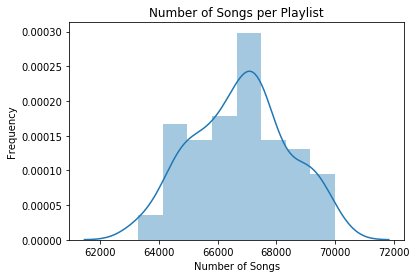

In [119]:
ax = sns.distplot([len(pl.index) for pl in playlists])
ax.set_title('Number of Songs per Playlist')
ax.set_xlabel("Number of Songs")
ax.set_ylabel('Frequency')

Text(17.200000000000003, 0.5, 'Playlist')

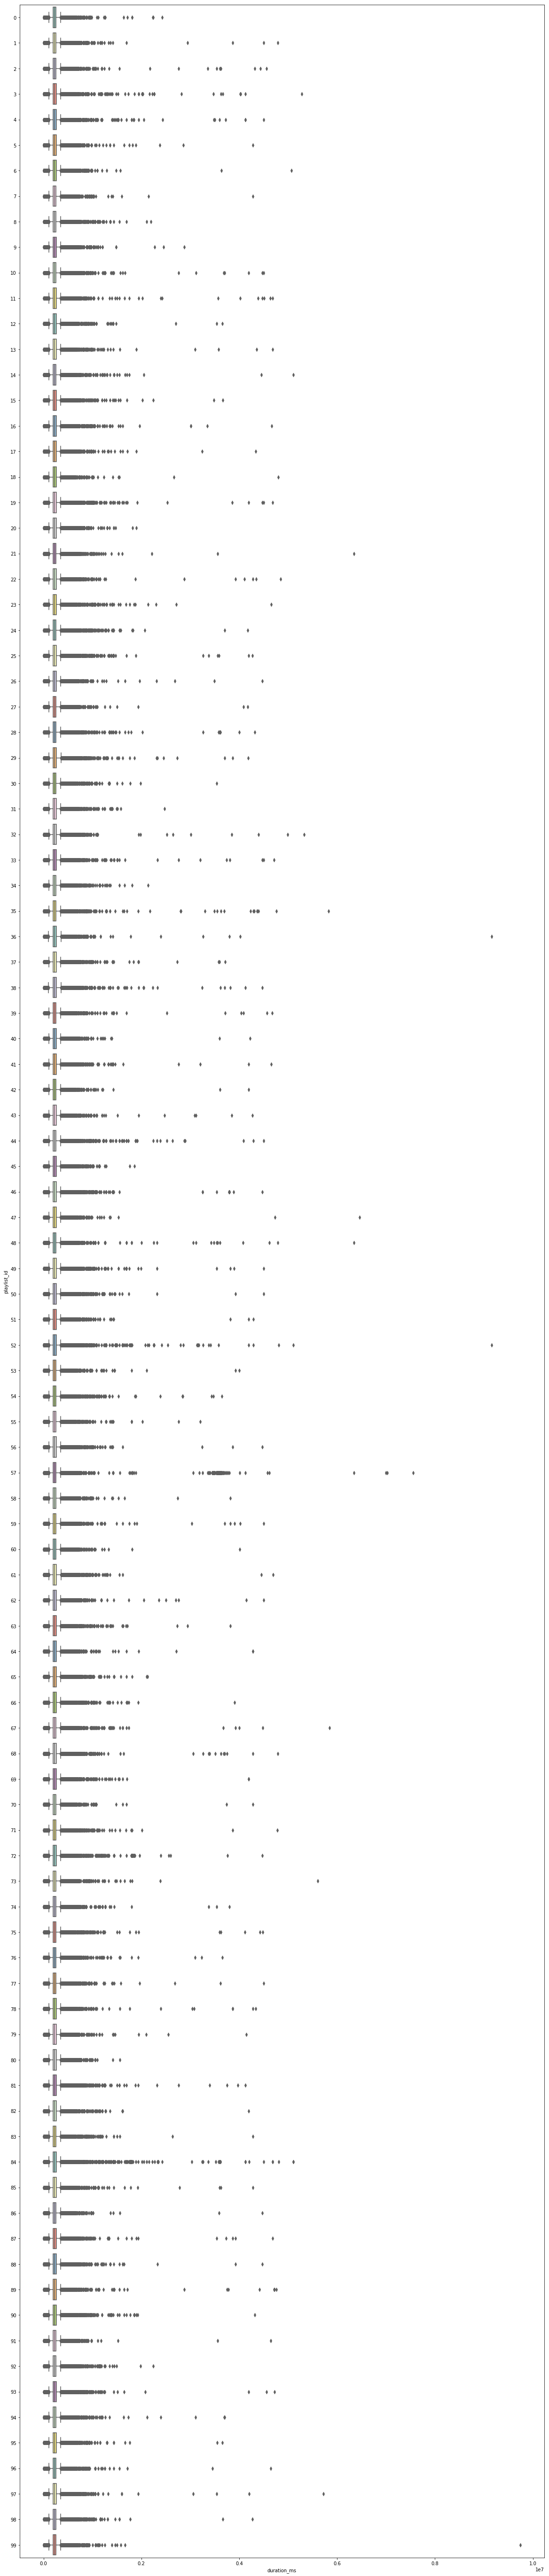

In [31]:
plt.figure(figsize=(20, 100))
sns.boxplot(x="duration_ms", y="playlist_id", data=all_songs, palette="Set3", orient = "h")
ax.set_title('Song Duration by Playlist')
ax.set_xlabel("Song Duration")
ax.set_ylabel('Playlist')


(10, 15)

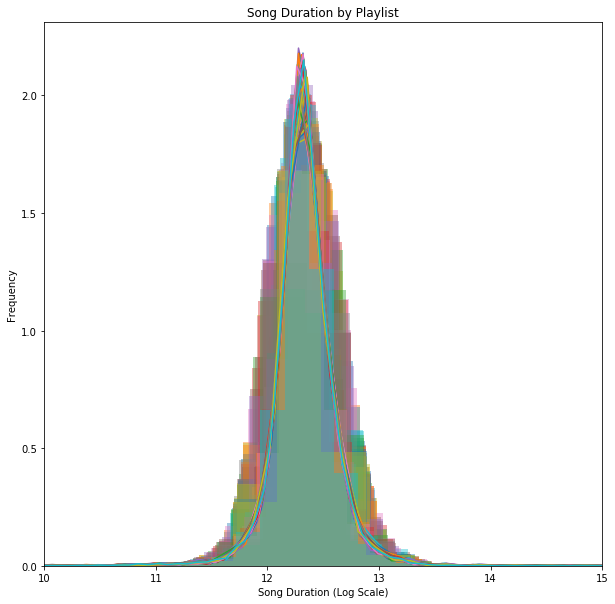

In [32]:
plt.figure(figsize=(10, 10))
for i in range(n_playlists):

    ax = sns.distplot(np.log(all_songs.loc[all_songs['playlist_id'] == i, ['duration_ms']] + 0.01))
ax.set_title('Song Duration by Playlist')
ax.set_xlabel("Song Duration (Log Scale)")
ax.set_ylabel('Frequency')
ax.set_xlim(10,15)

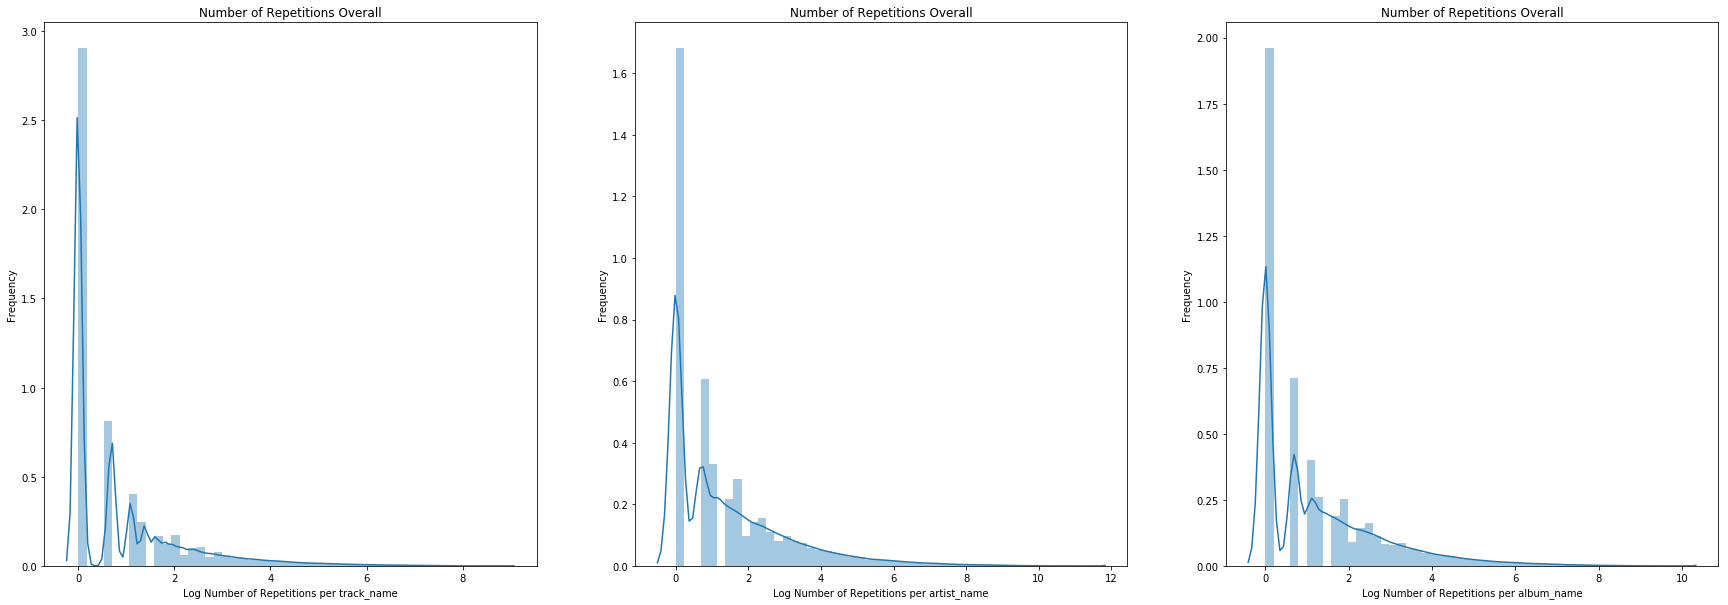

In [35]:
fig, axs = plt.subplots(1,3, figsize = (30,10))
attrs = ['track_name', 'artist_name', 'album_name']
for i, ax in enumerate(axs.ravel()):
    sns.distplot(np.log(all_songs[attrs[i]].value_counts()), ax = ax)
    ax.set_title('Number of Repetitions Overall')
    ax.set_xlabel("Log Number of Repetitions per {}".format(attrs[i]))
    ax.set_ylabel('Frequency')

In [36]:
# distribution of number of repetitions per song
all_songs['track_name'].value_counts().describe()

count    484279.000000
mean         13.789159
std          88.013276
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max        6844.000000
Name: track_name, dtype: float64

In [37]:
# distribution of number of repetitions per song
all_songs['artist_name'].value_counts().describe()

count    108091.000000
mean         61.779427
std         632.511007
min           1.000000
25%           1.000000
50%           2.000000
75%           9.000000
max       82460.000000
Name: artist_name, dtype: float64

In [38]:
# distribution of number of repetitions per album
all_songs['album_name'].value_counts().describe()

count    218621.000000
mean         30.545099
std         234.269590
min           1.000000
25%           1.000000
50%           2.000000
75%           8.000000
max       20342.000000
Name: album_name, dtype: float64

In [39]:
# unique songs per album
songs_per_album = all_songs.groupby('album_name')['track_name'].nunique()

Text(0, 0.5, 'Frequency')

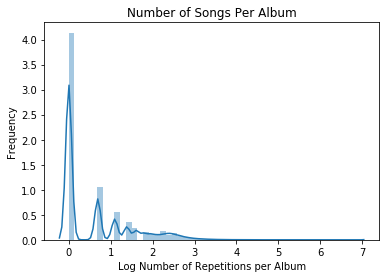

In [40]:
ax = sns.distplot(np.log(songs_per_album))
ax.set_title('Number of Songs Per Album')
ax.set_xlabel("Log Number of Repetitions per Album")
ax.set_ylabel('Frequency')

In [148]:
top_10_artists = all_songs['artist_name'].value_counts().nlargest(10)

In [42]:
top_100_albums = all_songs['album_name'].value_counts().nlargest(100)

Text(0, 0.5, 'Artist Name')

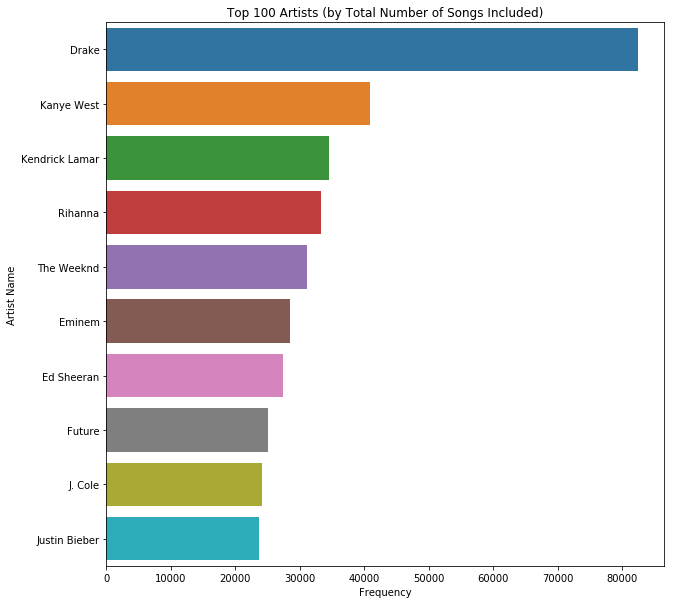

In [151]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=top_10_artists, y=top_10_artists.index)
ax.set_title('Top 100 Artists (by Total Number of Songs Included)')
ax.set_xlabel("Frequency")
ax.set_ylabel('Artist Name')


Text(0, 0.5, 'Album Name')

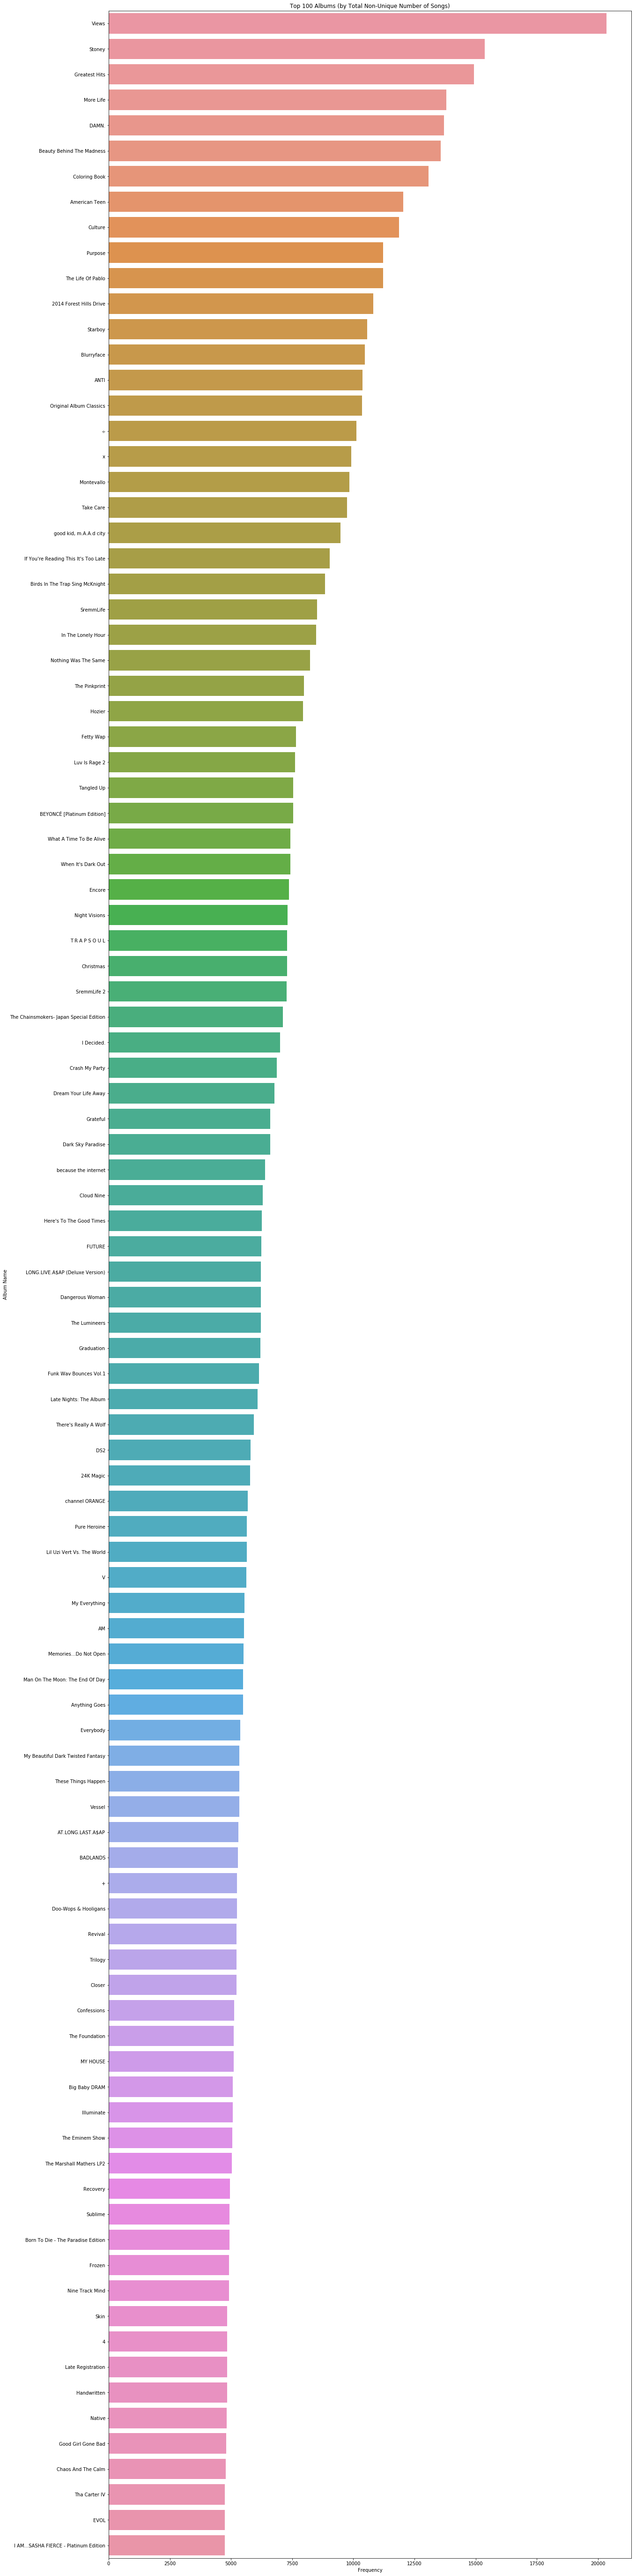

In [44]:
plt.figure(figsize=(20, 100))
ax = sns.barplot(x=top_100_albums, y=top_100_albums.index)
ax.set_title('Top 100 Albums (by Total Non-Unique Number of Songs)')
ax.set_xlabel("Frequency")
ax.set_ylabel('Album Name')

## SPOTIFY API
The Spotify API offers a lot of information that we could potentially use, and we decided to explore its functionality by looking at visual representations of some of the attributes of songs that we thought might be most important for predicting music taste, on a random sample of 30 songs. 

In [120]:
random_seed = 109
np.random.seed(random_seed)
sample_songs = all_songs.sample(n = 10)
rand_ids = [track[14:] for track in sample_songs.track_uri]
rand_ids

['5KY7zgFeH2GWoL1zP9mME6',
 '5wQnmLuC1W7ATsArWACrgW',
 '5sdYtv8t8dWGCPaSqYJkY4',
 '2bjwRfXMk4uRgOD9IBYl9h',
 '1HCw8XKtTgWWU3JlEUR0qQ',
 '0d28khcov6AiegSCpG5TuT',
 '6VixoRqnikN4QqegoKUSbH',
 '5rgrBsAFYMun6yhtnLKRPz',
 '7vtuYSHkY01YTT5djvKQZw',
 '30ST8wGrUm3puztIO4wFV2']

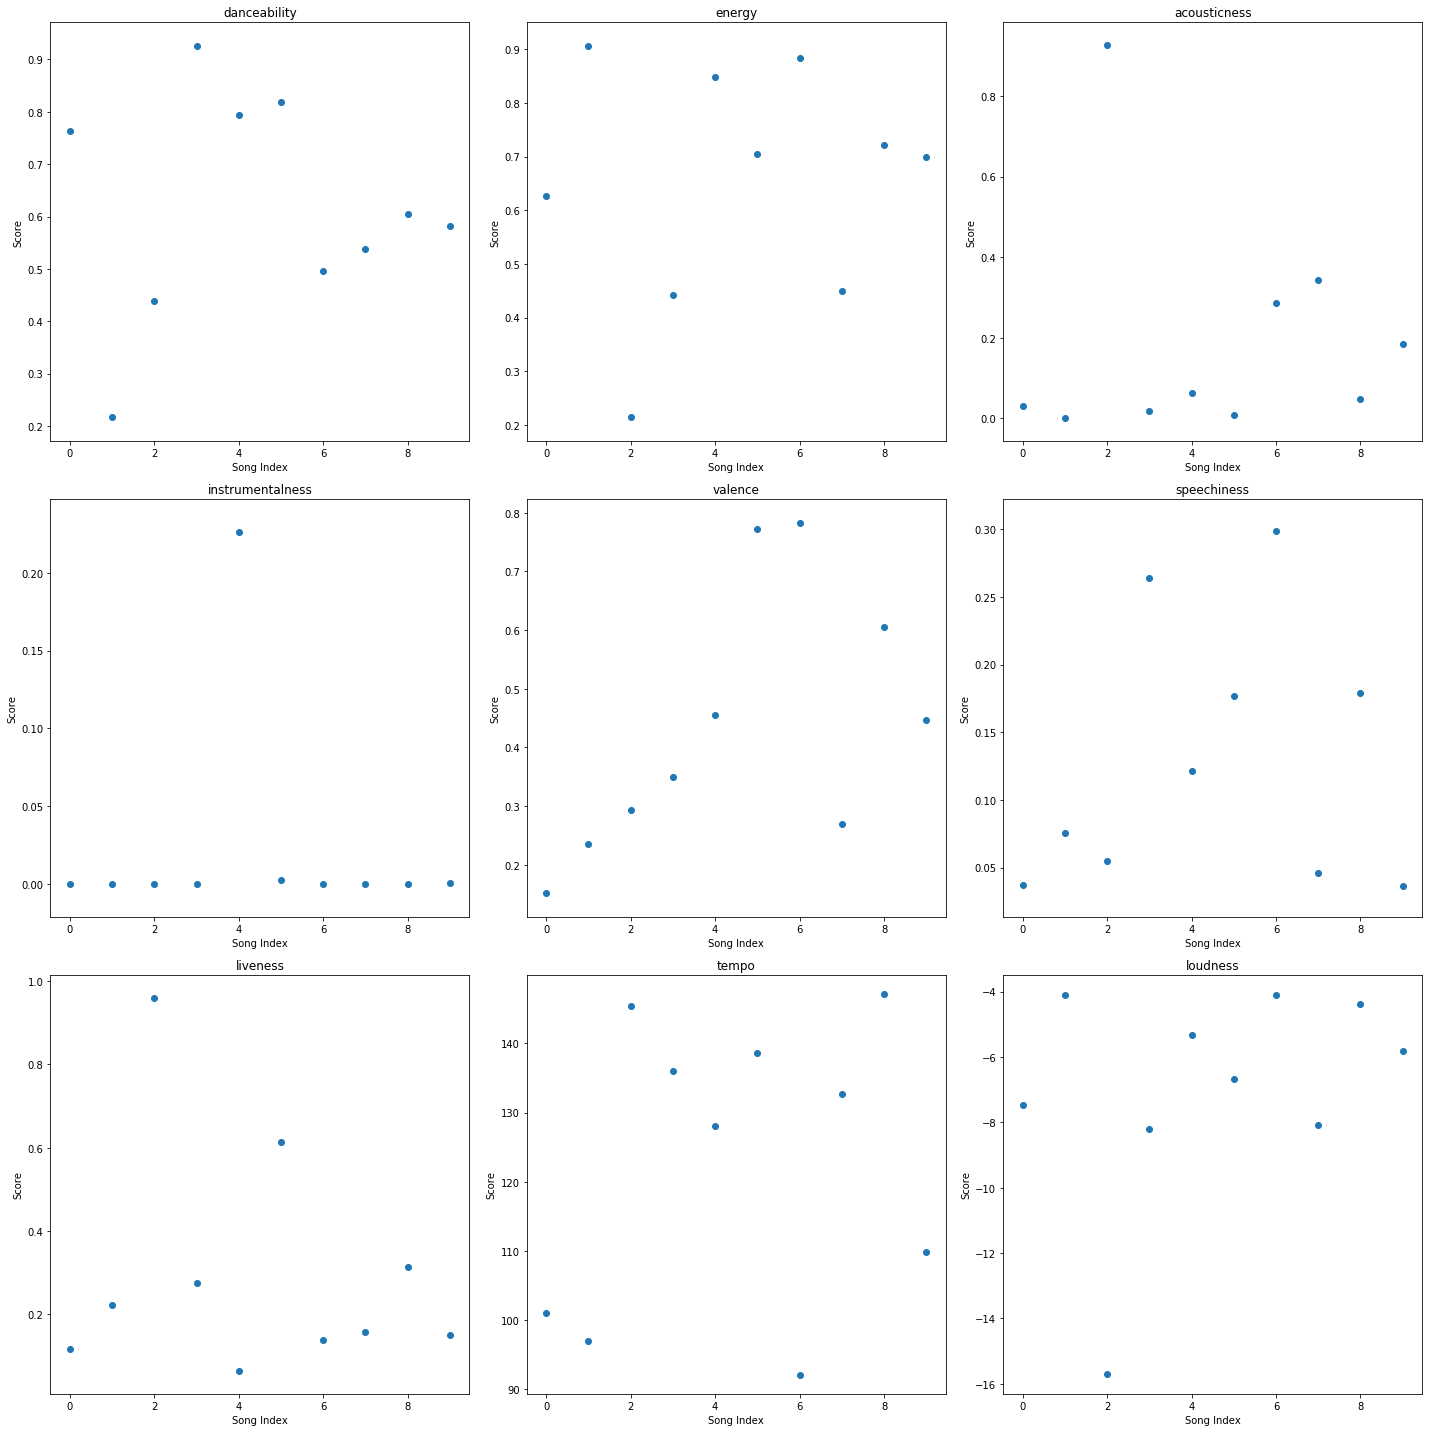

In [125]:
random_seed = 109
np.random.seed(random_seed)
sample_songs = all_songs.sample(n = 10)
rand_ids = [track[14:] for track in sample_songs.track_uri]
# rand_ids = ['spotify:track:7xYnUQigPoIDAMPVK79NEq',
#        'spotify:track:3QZ7uX97s82HFYSmQUAN1D',
#        'spotify:track:07Tx168RSsUS1HqkDIOZbH',
#        'spotify:track:2yNUAnFrAJkV0eilMxeA19',
#        'spotify:track:2LEF1A8DOZ9wRYikWgVlZ8',
#        'spotify:track:1hWQvA6oGVJ2mAVsZ59AaV',
#        'spotify:track:6y20BV5L33R8YXM0YuI38N',
#        'spotify:track:03WuFsWpkytZ6c5iidS8Im',
#        'spotify:track:3e21cX0CVwzkQXiHz7WUQZ',
#        'spotify:track:2RUuKIHFHjk41E7YsJ9HNP',
#        'spotify:track:3WS7spXVlbeC5kjePmHMQW',
#        'spotify:track:7jOM0KIKgIppqIEvEjixaj',
#        ]
info = spotify.audio_features(rand_ids)
features = ["danceability", "energy", "acousticness", "instrumentalness", "valence", "speechiness", "liveness", "tempo", "loudness"]
fig, axs = plt.subplots(3,3, figsize = (20,20))
for i, ax in enumerate(axs.ravel()):
    ax.scatter(np.arange(0, 10), [track[features[i]] for track in info])
    ax.set_title(features[i])
    ax.set_xlabel("Song Index")
    ax.set_ylabel('Score')
fig.tight_layout()


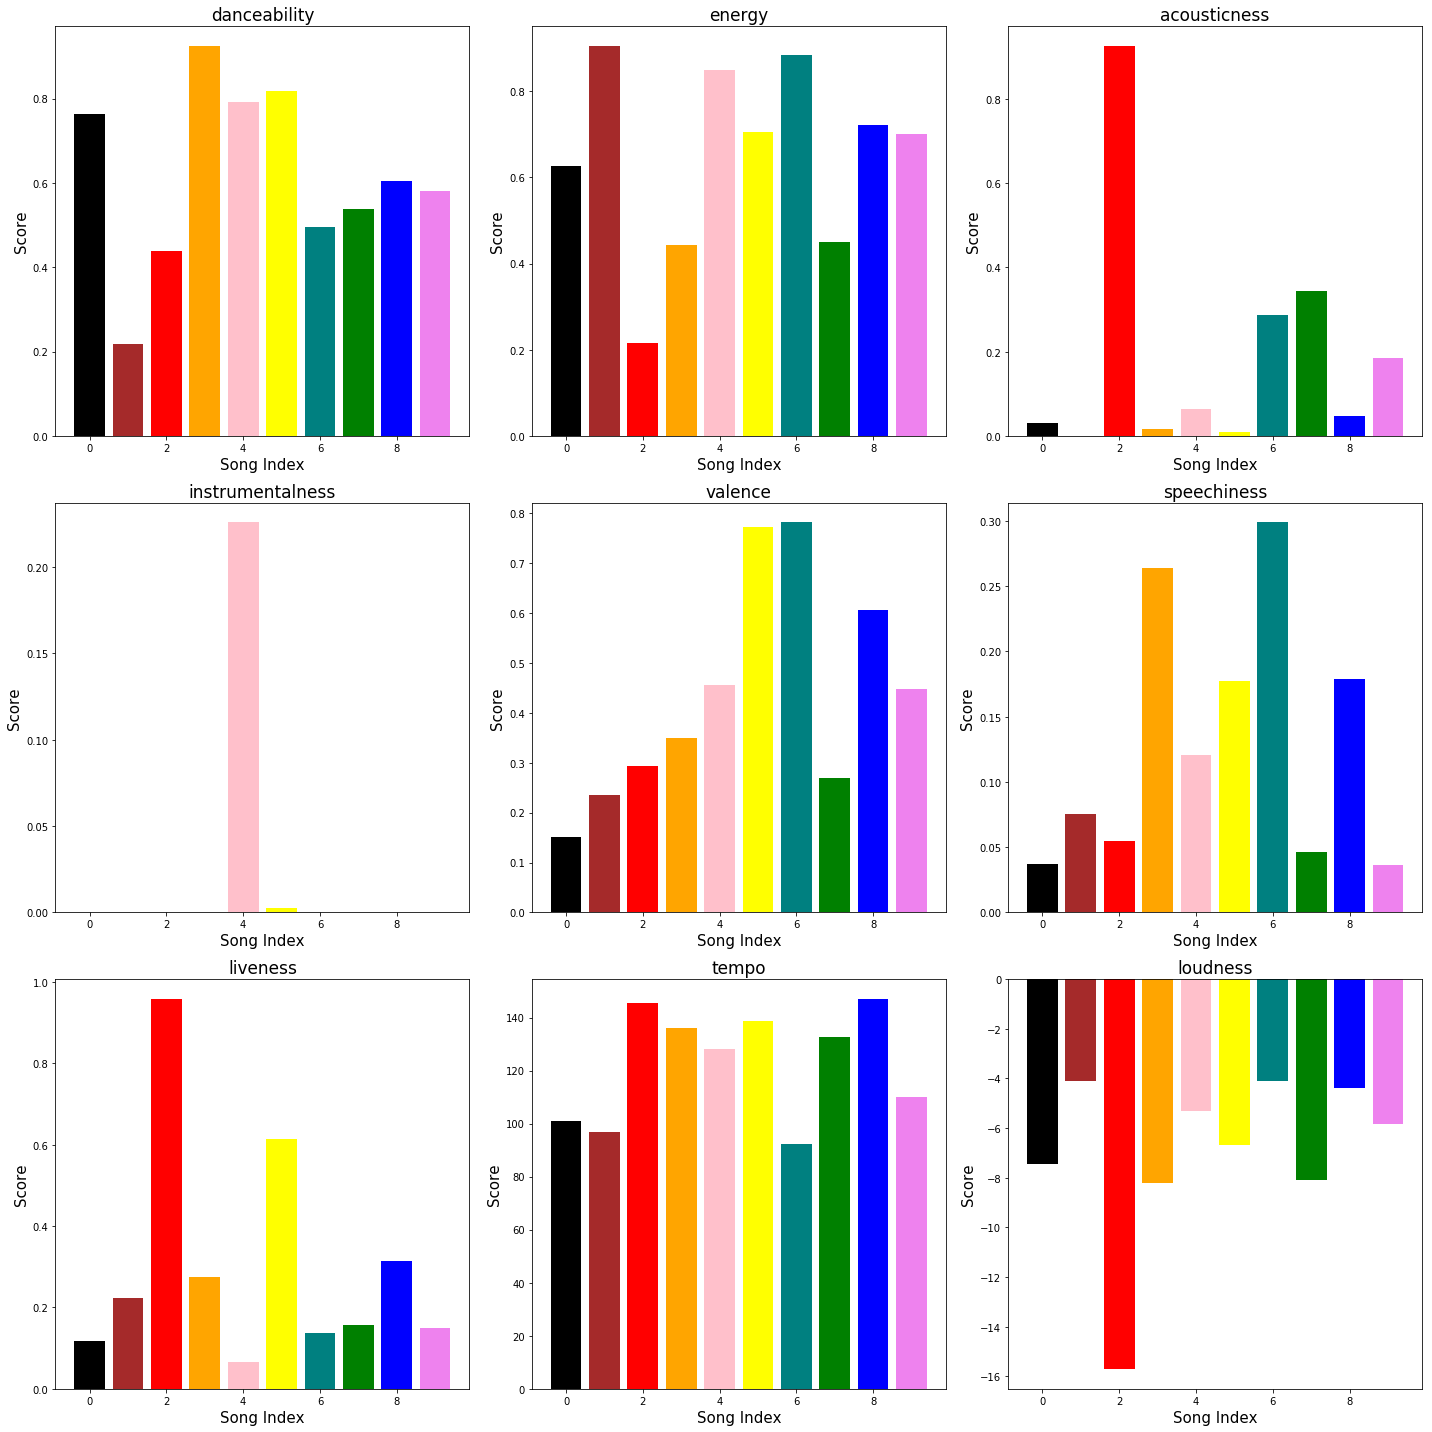

In [147]:
fig, axs = plt.subplots(3,3, figsize = (20,20))
for i, ax in enumerate(axs.ravel()):
    ax.bar(np.arange(0, 10), [track[features[i]] for track in info],
           color=['black','brown', 'red', 'orange', 'pink','yellow', 'teal','green', 'blue', 'violet'])
    ax.set_title(features[i], fontsize = 17)
    ax.set_xlabel("Song Index", fontsize = 15)
    ax.set_ylabel('Score', fontsize = 15)
  
fig.tight_layout()
plt.savefig('barplot_song_score.png')

There didn't seem to any striking correlations between any of the attributes, but we suspect that audio features such as speechiness and acousticness may have some colinearity, so when we create our final model we will likely use some form of Lasso-liek regularization to pare down the features we use as our predictors.

## Genius Lyrics

For lyrics scraping, we were going to use the Lyrics Wiki website provided but we found that the section we were interested in, top 100 songs, was not available anymore. So, instead we used the lyrics from Genius's Top 100 Pop Songs. Note that these songs were chosen for EDA purposes, but could be applied to Spotify songs in the future. 

After doing some initial EDA of the lyrics, we decided that the distribution of frequency of words likely won't be super useful in informing our model, because sentiment that might be communicated via lyrics would probably also be encoded in the valence attribute available through the Spotify API.

In [20]:
my_page = requests.get("https://genius.com/Genius-top-100-pop-songs-lyrics")
my_page.status_code


200

In [21]:
top100 = my_page.text
star_soup = BeautifulSoup(top100, "html.parser")
print (star_soup.prettify()[:])

<!DOCTYPE html>
<html class="snarly apple_music_player--enabled bagon_song_page--enabled song_stories_public_launch--enabled react_forums--disabled" lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml">
 <head>
  <base href="//genius.com/" target="_top"/>
  <script type="text/javascript">
   //<![CDATA[

  var _sf_startpt=(new Date()).getTime();
  if (window.performance && performance.mark) {
    window.performance.mark('parse_start');
  }

//]]>
  </script>
  <title>
   Genius – Top 100 Pop Songs Lyrics | Genius Lyrics
  </title>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="width=device-width,initial-scale=1" name="viewport"/>
  <meta content="app-id=709482991" name="apple-itunes-app"/>
  <link href="https://assets.genius.com/images/apple-touch-icon.png?1574282829" rel="apple-touch-icon"/>
  <link href="https://assets.genius.com/images/apple-touch-icon.png?1574282829" rel="apple-touch-icon"

In [22]:
PUB_FILENAME = 'https://genius.com/Genius-top-100-pop-songs-lyrics'

In [23]:
star_soup.find('div', attrs={'class':'lyrics'})

<div class="lyrics">
<!--sse-->
<p>1.	<a annotation-fragment="7777178" class="referent" classification="accepted" data-id="7777178" href="/Genius-top-100-pop-songs-lyrics#note-7777178" image="false" ng-class="{
          'referent--linked_to_preview': song_ctrl.referent_has_preview(fragment_id),
          'referent--linked_to_preview_active': song_ctrl.highlight_preview_referent(fragment_element_id),
          'referent--purple_indicator': song_ctrl.show_preview_referent_indicator(fragment_element_id)
        }" ng-click="open()" on-hover-with-no-digest="set_current_hover_and_digest(hover ? fragment_id : undefined)" pending-editorial-actions-count="0" prevent-default-click="">Beyoncé	-	Drunk In Love</a><br/>
2.	<a annotation-fragment="7777210" class="referent" classification="accepted" data-id="7777210" href="/Genius-top-100-pop-songs-lyrics#note-7777210" image="false" ng-class="{
          'referent--linked_to_preview': song_ctrl.referent_has_preview(fragment_id),
          'referent-

### Creating List of Dictionaries of Lyrics

In this part, after reading in the url from Genius, we wanted to scrape the artist and the song in order to create a URL ending. Genius has a very organized way of writing their URLs where it is "genius.com/artist-name-song-title-lyrics." So, by getting all of the artists and their corresponding songs, we can create URLs that lead to the song's lyrics.

In [24]:
starlist = []
def parse_stars(star_soup):
    for star in star_soup.find_all('a', attrs={'class':'referent'}):
        d = dict()
        d['name'] = '-'.join(star.text.strip().split("\t-\t")[0].split()).replace('---What-Do-You-Mean?', '').replace('é', 'e')
        thing = '-'.join(star.text.split("\t-\t",1)[-1].split())
        d['song'] = thing.replace("*","").replace('-(Remix)', '').replace('-(Remix)', '').replace('-✓','').replace('---','-').replace('---','-').replace('✓','').replace('?','').replace('&','and').replace('/','-').replace('Justin-Bieber-','').replace("'",'')
        d['url ending']=d['name']+'-'+d['song']
        starlist.append(d)
    return starlist
parse_stars(star_soup)


[{'name': 'Beyonce',
  'song': 'Drunk-In-Love',
  'url ending': 'Beyonce-Drunk-In-Love'},
 {'name': 'The-Weeknd',
  'song': 'The-Hills',
  'url ending': 'The-Weeknd-The-Hills'},
 {'name': 'Robin-Thicke',
  'song': 'Blurred-Lines',
  'url ending': 'Robin-Thicke-Blurred-Lines'},
 {'name': 'Eminem', 'song': 'The-Monster', 'url ending': 'Eminem-The-Monster'},
 {'name': 'Macklemore-and-Ryan-Lewis',
  'song': 'Thrift-Shop',
  'url ending': 'Macklemore-and-Ryan-Lewis-Thrift-Shop'},
 {'name': 'Daft-Punk',
  'song': 'Get-Lucky',
  'url ending': 'Daft-Punk-Get-Lucky'},
 {'name': 'Macklemore-and-Ryan-Lewis',
  'song': 'Cant-Hold-Us',
  'url ending': 'Macklemore-and-Ryan-Lewis-Cant-Hold-Us'},
 {'name': 'Beyonce', 'song': 'Partition', 'url ending': 'Beyonce-Partition'},
 {'name': 'Frank-Ocean',
  'song': 'Thinkin-Bout-You',
  'url ending': 'Frank-Ocean-Thinkin-Bout-You'},
 {'name': 'Nicki-Minaj',
  'song': 'Feeling-Myself',
  'url ending': 'Nicki-Minaj-Feeling-Myself'},
 {'name': 'Nicki-Minaj', 'so

There is a Genius API that we retrieved from "https://www.johnwmillr.com/scraping-genius-lyrics/" where one can easily scrape the lyrics of any song from genius.com. We will be using this to create the genius urls and scrape the entire set of lyrics.

In [25]:
# THIS CHUNK TAKES A LONG TIME TO RUN - lyrics_list is stored in pickle file
# dictionary = parse_stars(star_soup)
# url_endings = list(map(itemgetter('url ending'), dictionary))
# lyrics_list = []
# for i in url_endings:
#     URL = f'https://genius.com/{i}-lyrics'
#     page = requests.get(URL)
#     html = BeautifulSoup(page.text, "html.parser") # Extract the page's HTML as a string
#     #html = str(html)
#     try:
#         lyrics = html.find("div", class_="lyrics").get_text()
#     except:
#         lyrics = ''
#     lyrics_list.append(lyrics)

In [26]:
# with open('lyrics_list.pickle', 'wb') as f:
#     pickle.dump(lyrics_list, f)

with open('lyrics_list.pickle', 'rb') as f:
    lyrics_list = pickle.load(f)

### NLTK Analysis

Now we want to analyze the characteristics of the lyrics for the top 100 pop songs using NLTK.

In [28]:
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in lyrics_list]
lyrics_new_list = []
for i in stripped:
    stripped = i.replace('\n', ' ')
    lyrics_new_list.append(stripped)
from nltk.tokenize import sent_tokenize
token = []
for text in lyrics_new_list:
    tokenized_text=sent_tokenize(text)
    token.append(tokenized_text)
from nltk.tokenize import word_tokenize

words = []
for word in token:
    tokenized_word=word_tokenize(str(word))
    words.append(tokenized_word)

In [29]:
#this will clean the lyrics by removing all of the stop words
#this will provide the words for every word in all of the 100 song lyrics
#saved in filter_word
stop_words=set(stopwords.words('english'))
filtered_sent=[]
for w in words:
    for j in w:
        if j not in stop_words:
            j
        filtered_sent.append(j)


Now we want to look at the frequency distributions of the top words in each of the songs.

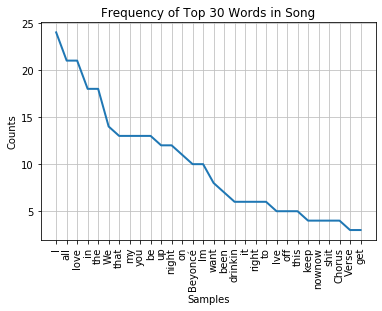

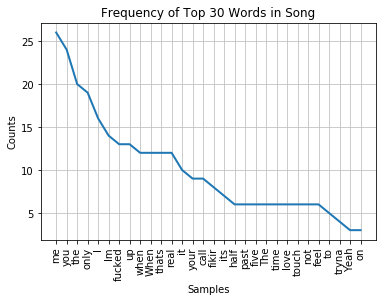

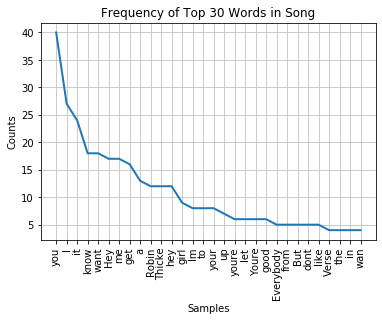

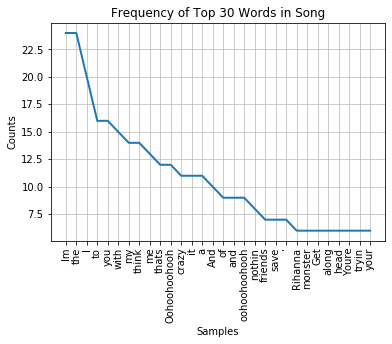

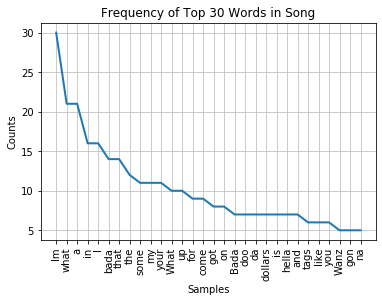

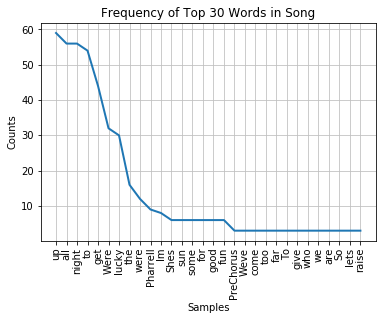

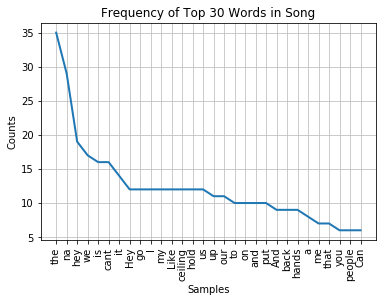

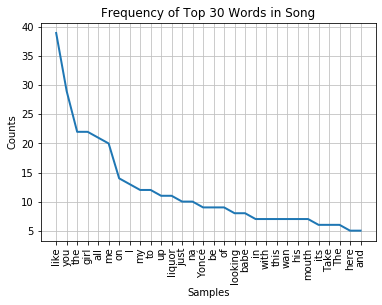

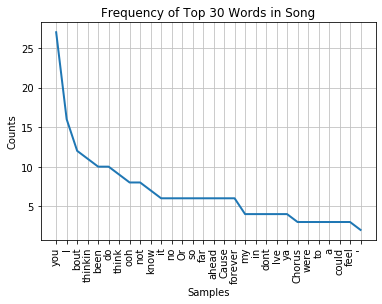

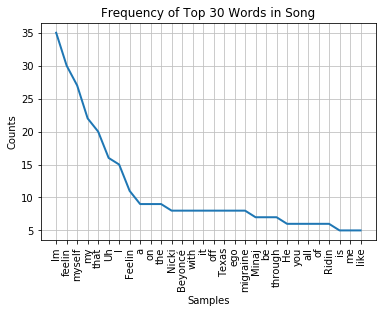

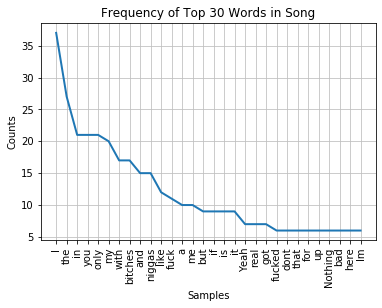

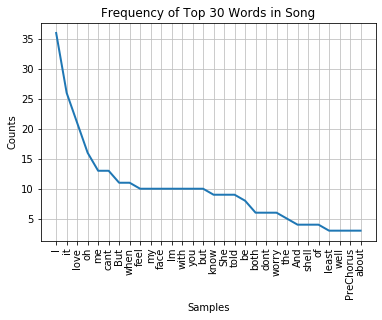

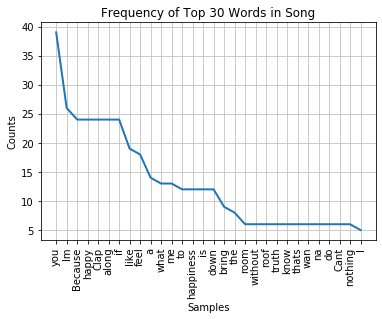

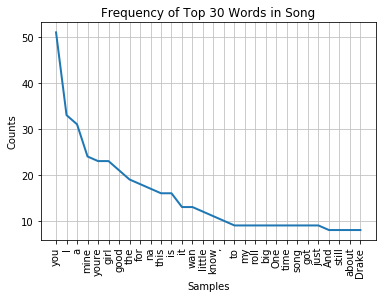

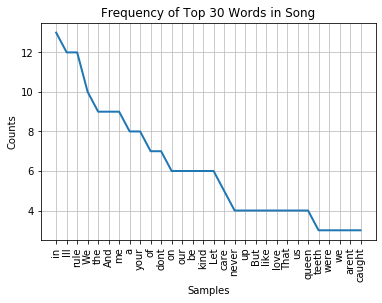

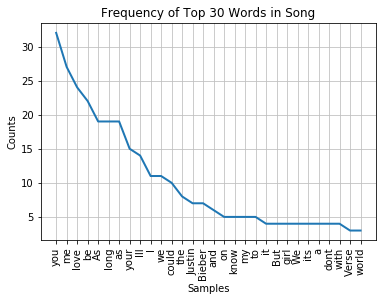

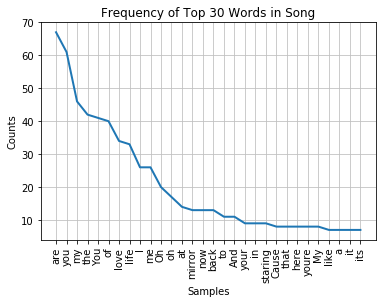

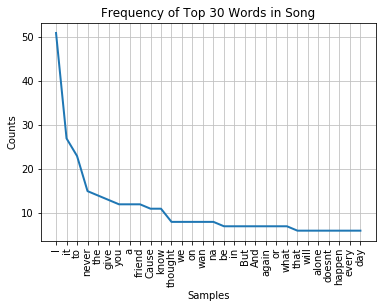

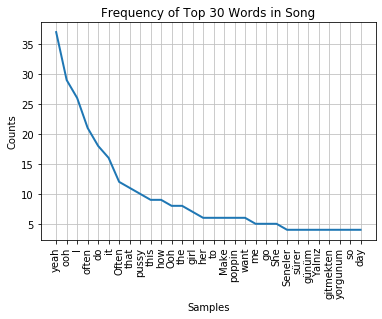

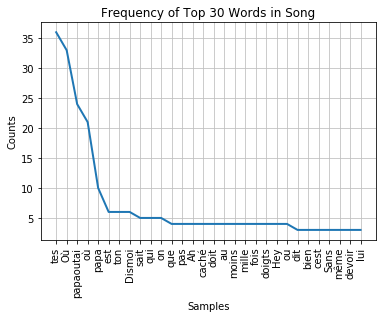

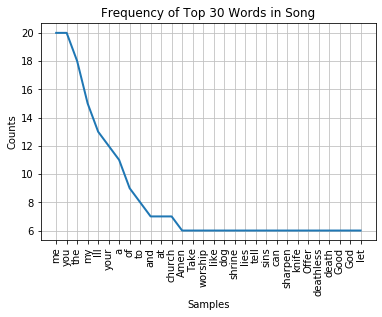

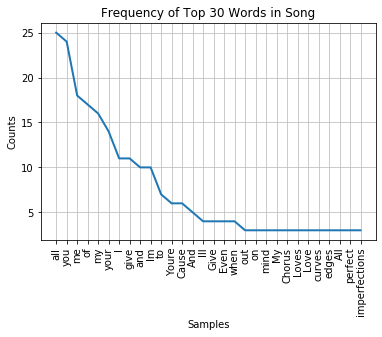

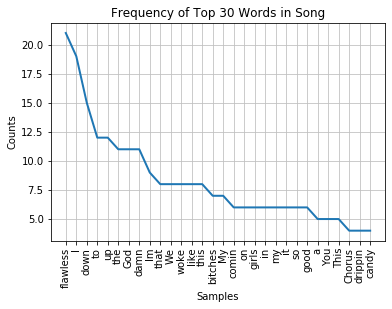

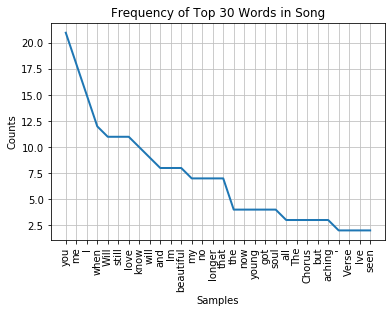

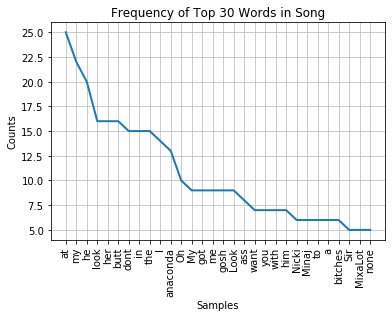

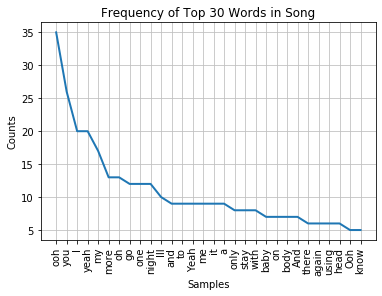

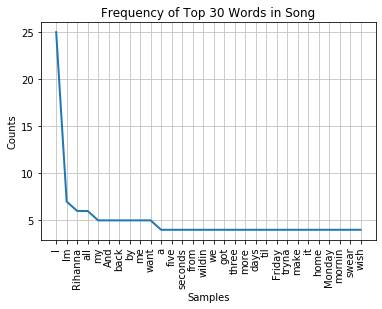

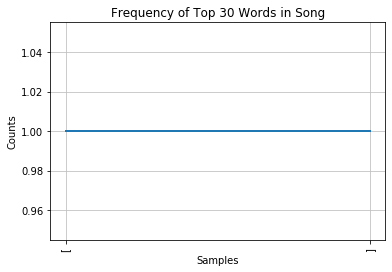

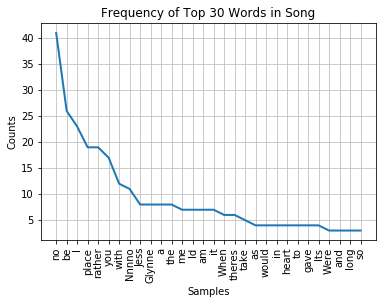

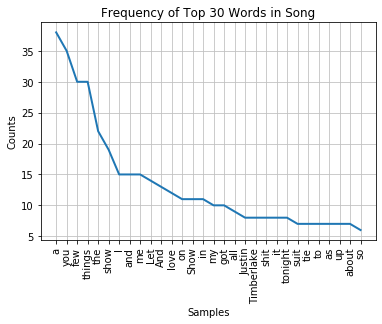

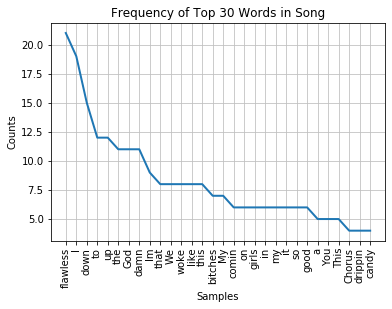

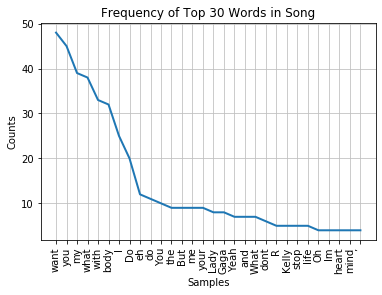

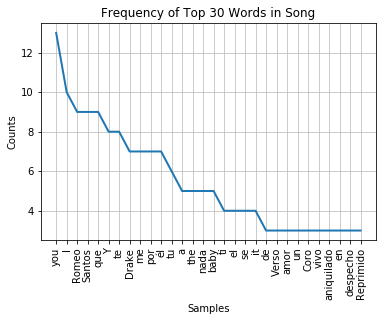

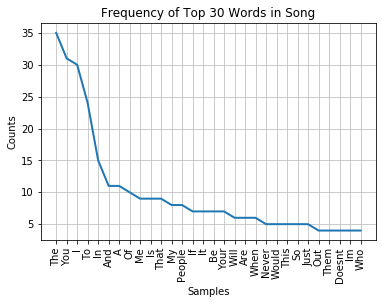

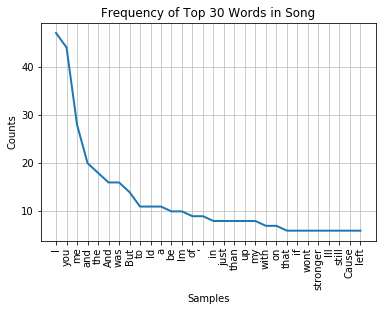

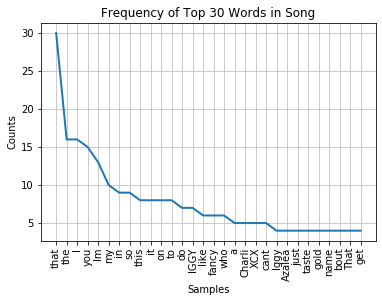

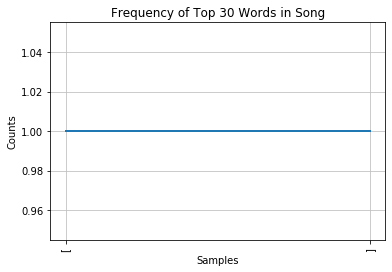

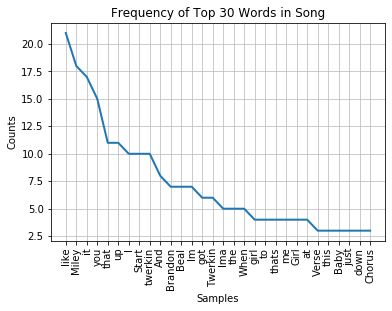

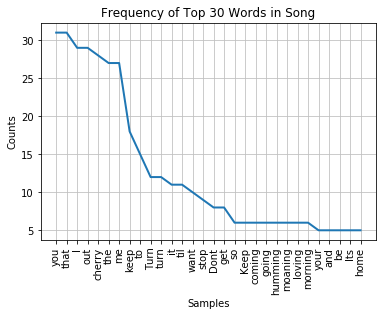

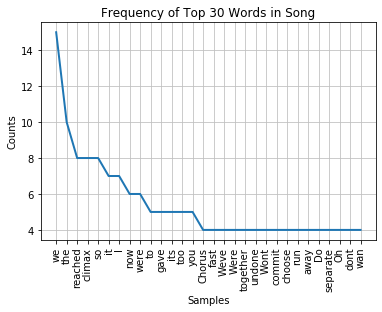

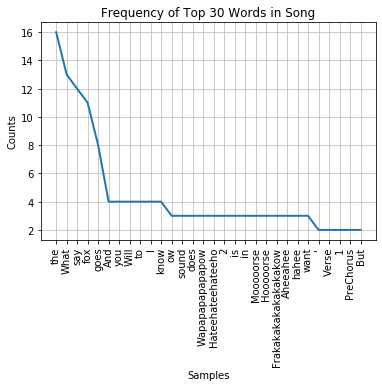

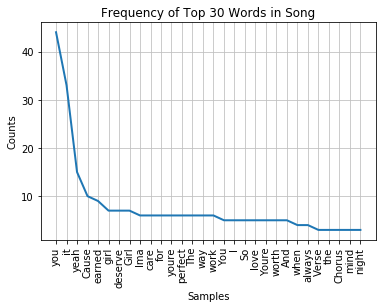

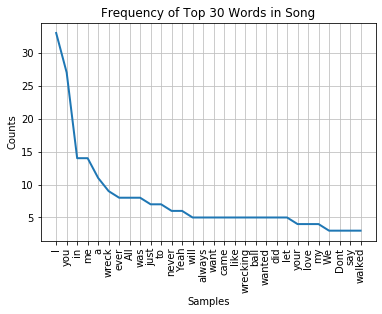

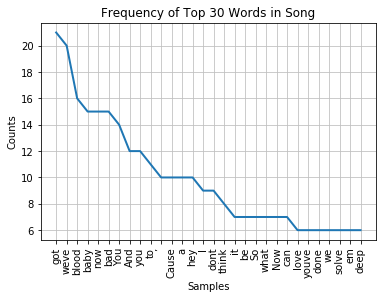

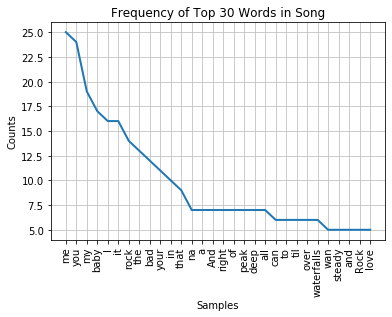

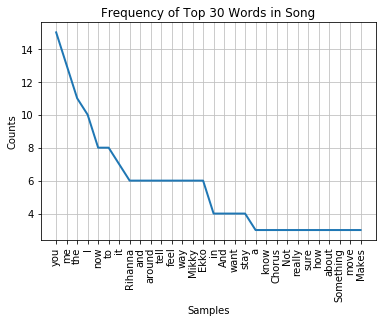

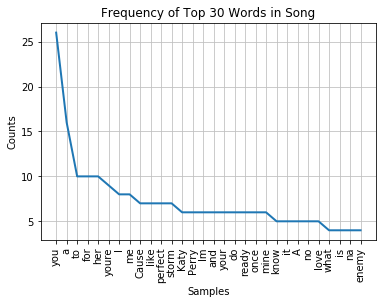

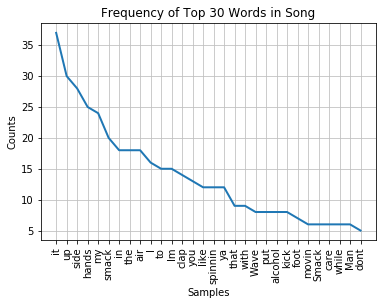

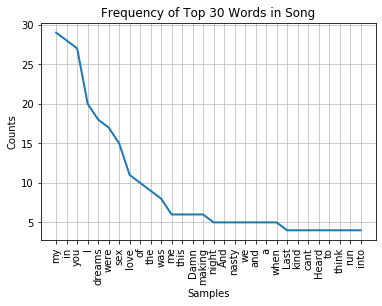

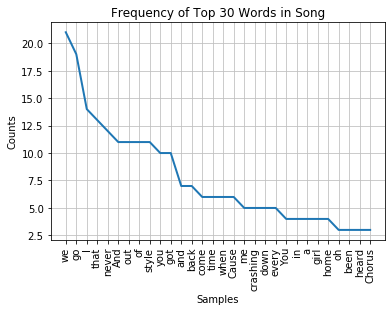

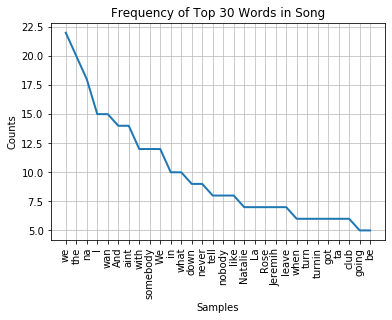

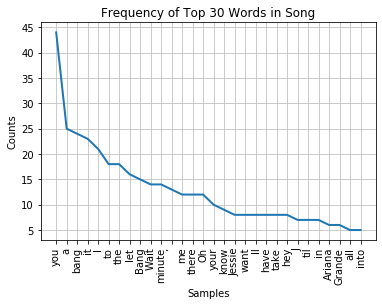

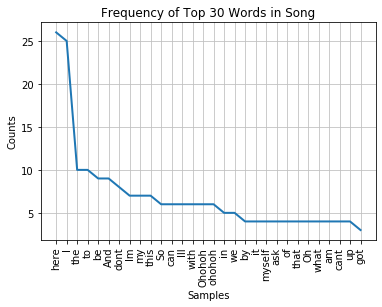

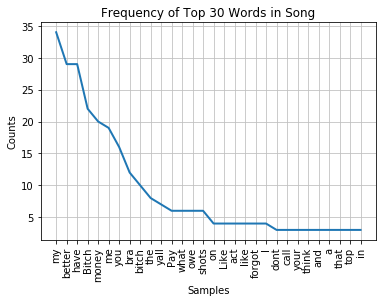

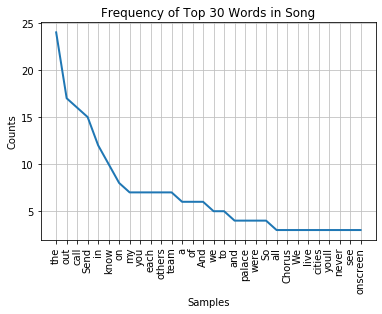

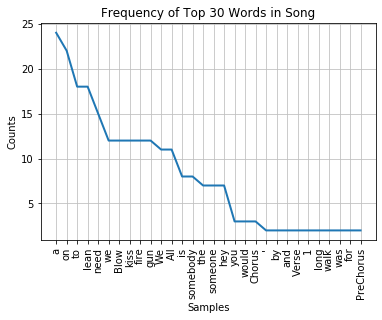

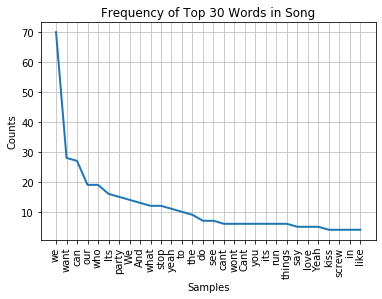

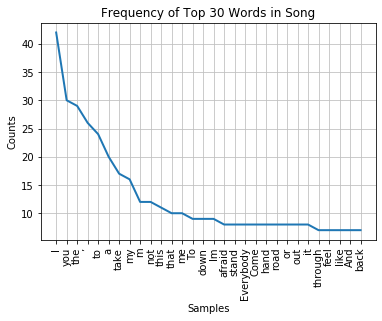

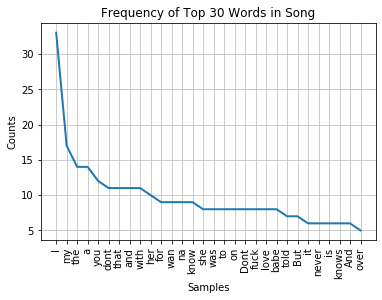

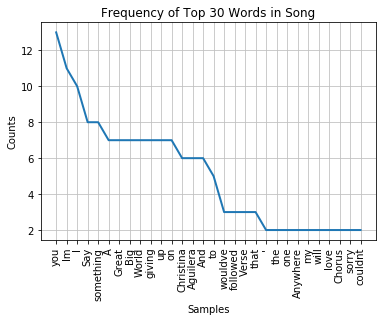

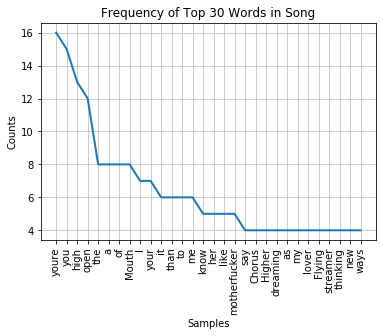

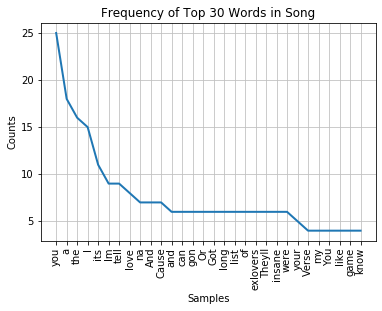

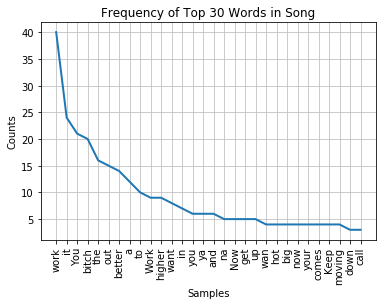

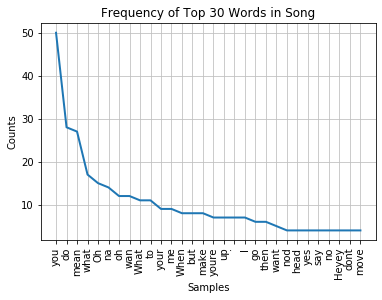

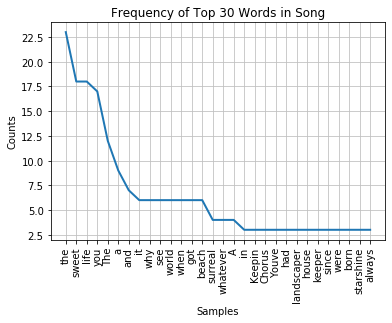

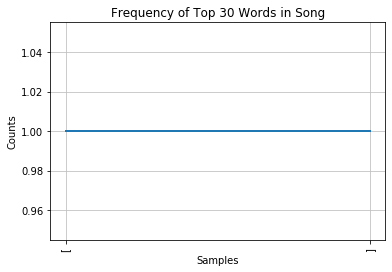

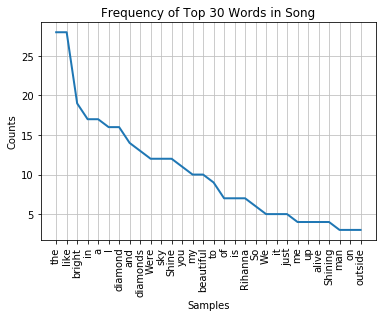

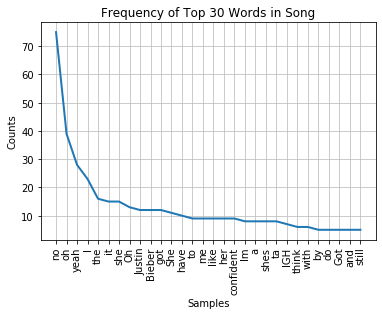

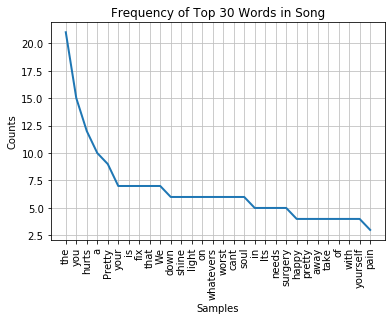

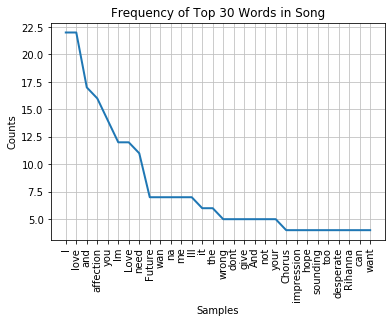

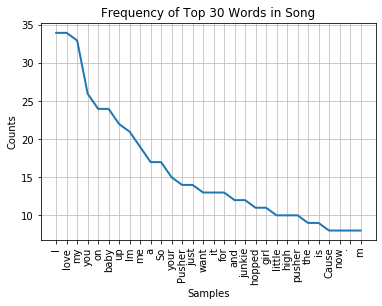

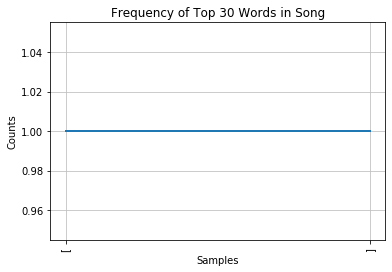

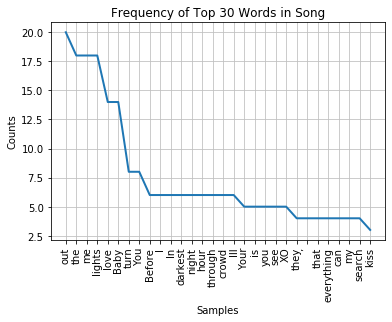

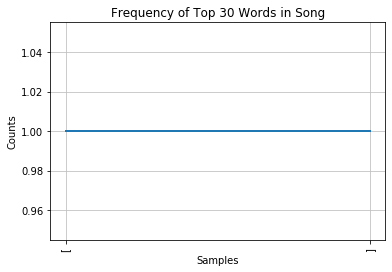

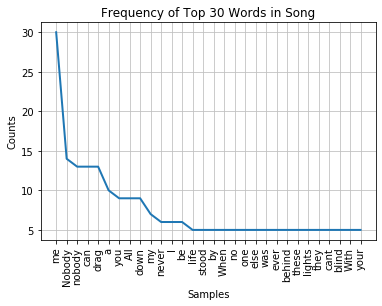

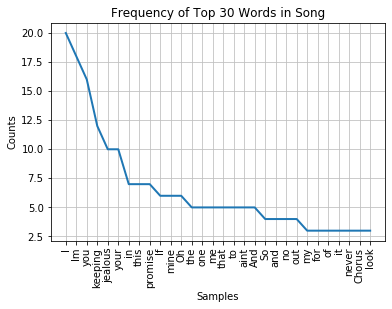

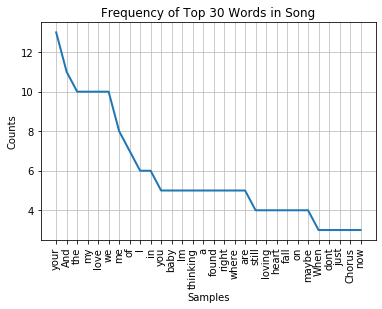

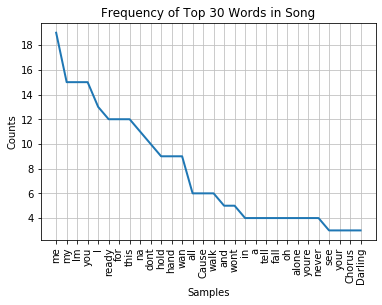

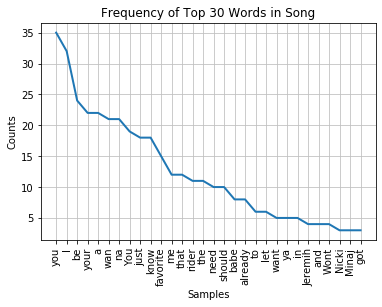

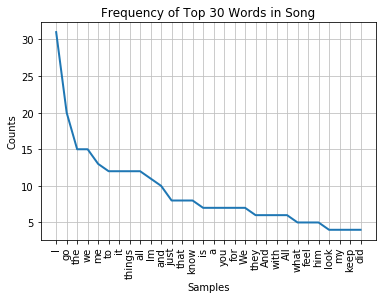

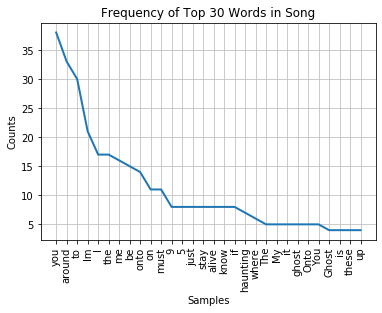

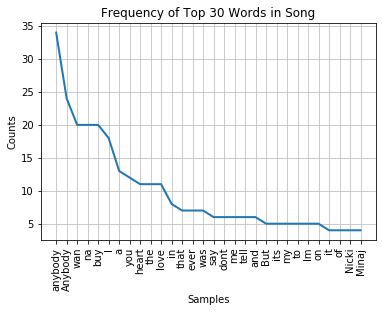

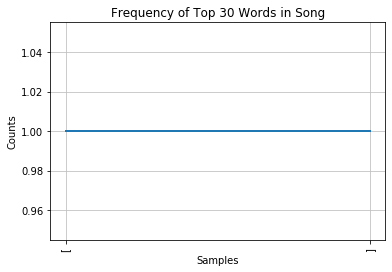

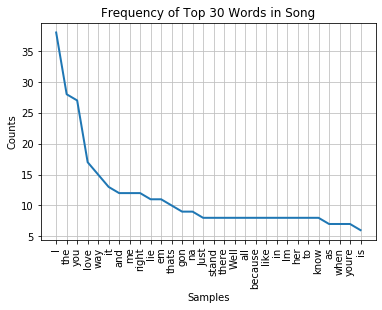

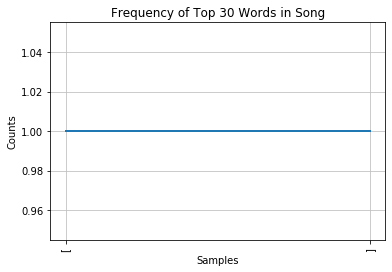

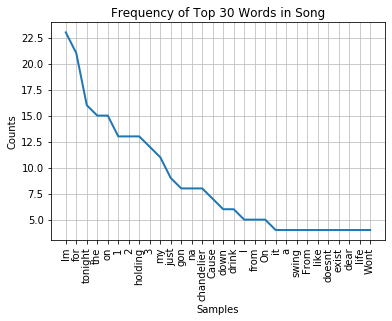

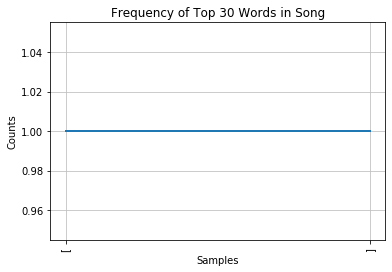

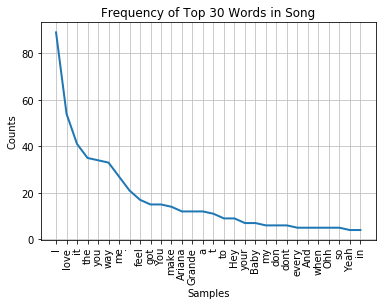

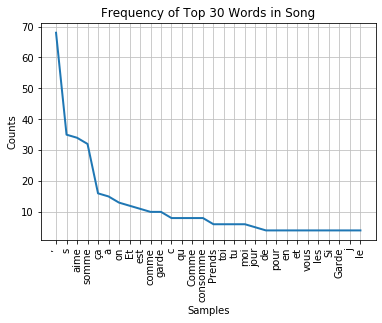

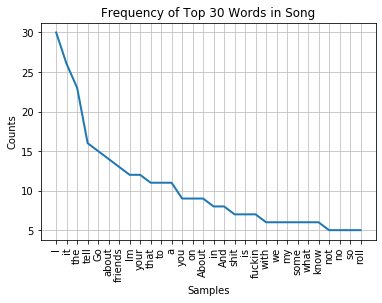

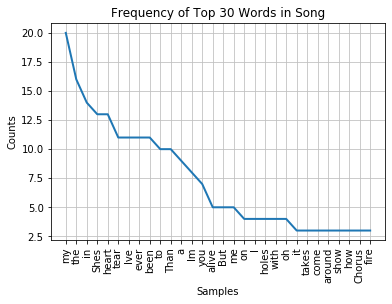

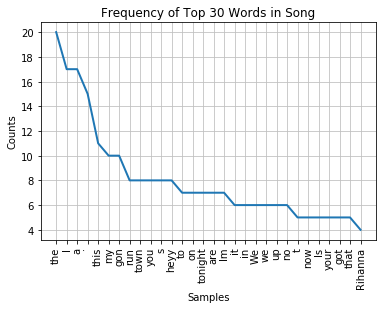

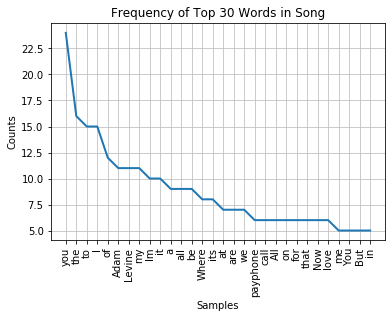

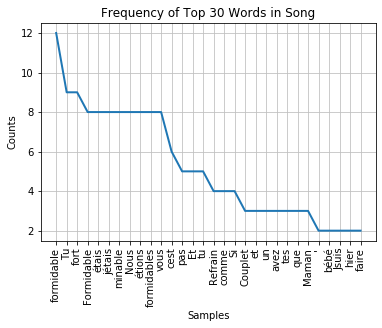

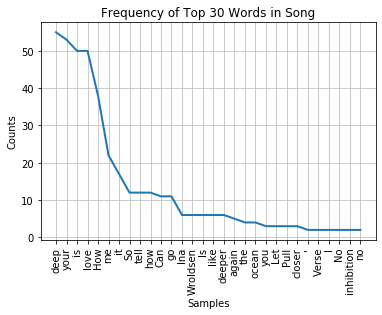

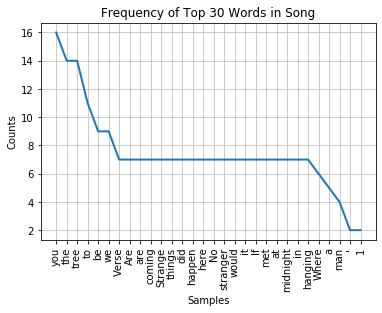

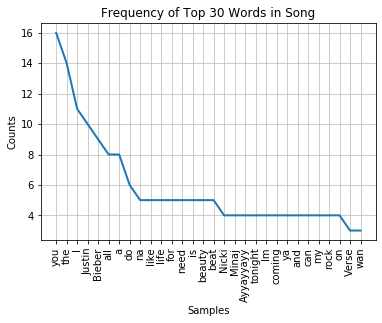

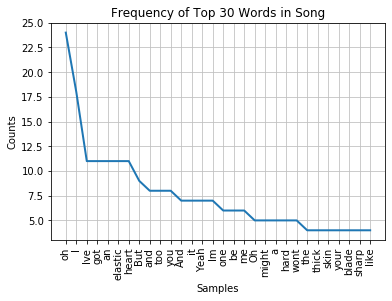

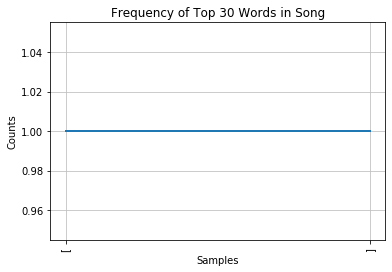

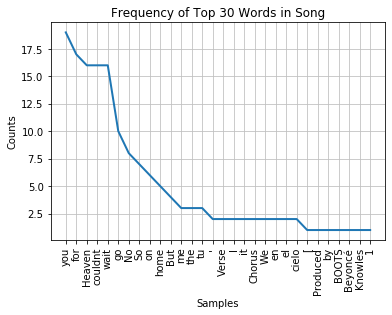

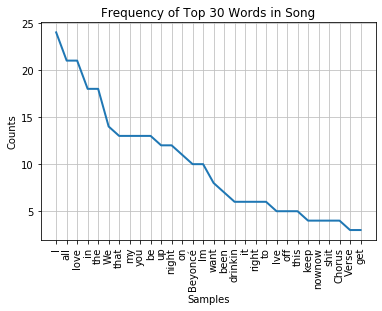

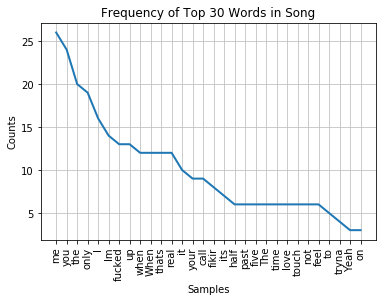

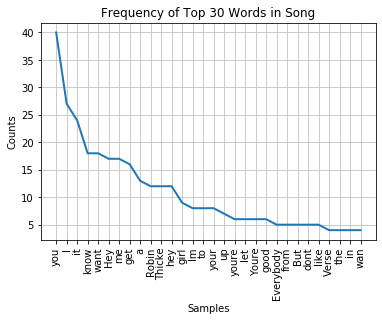

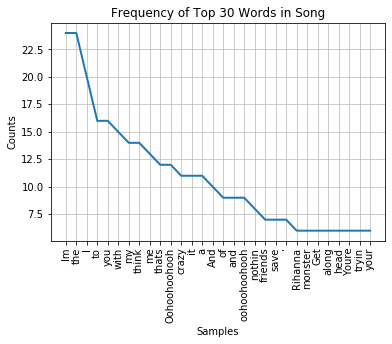

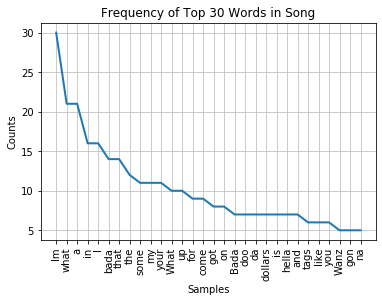

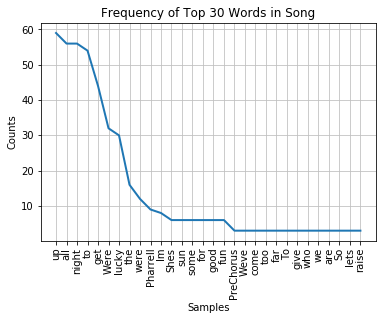

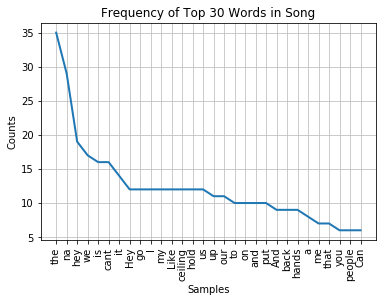

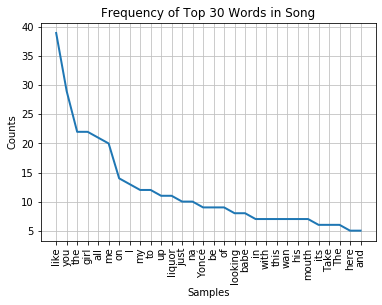

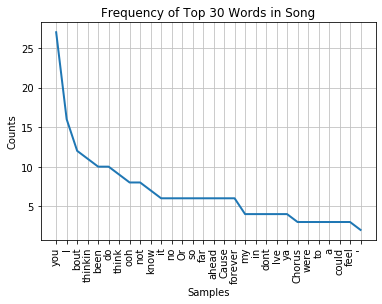

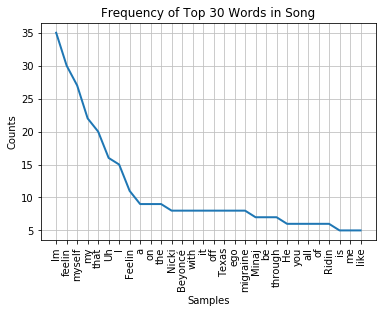

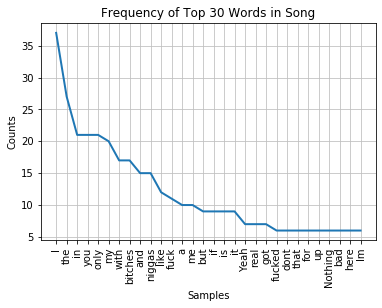

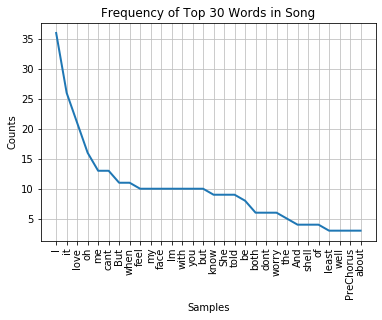

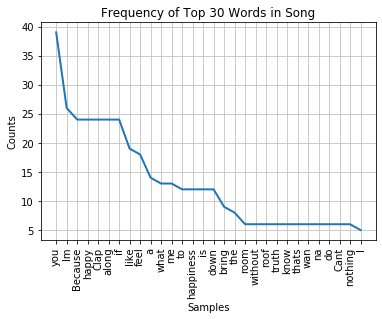

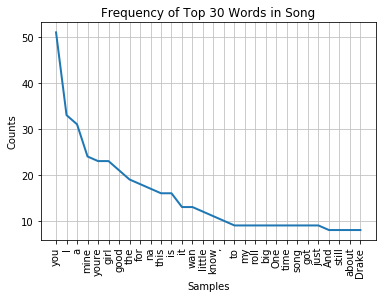

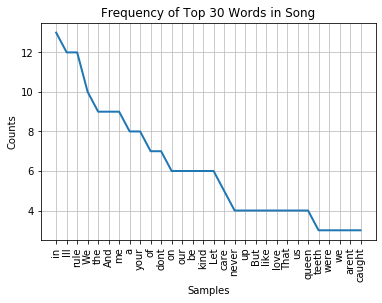

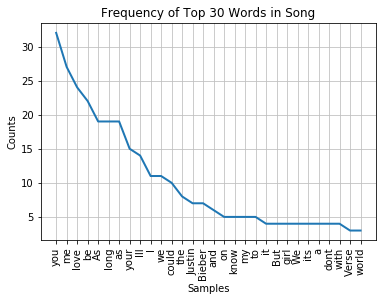

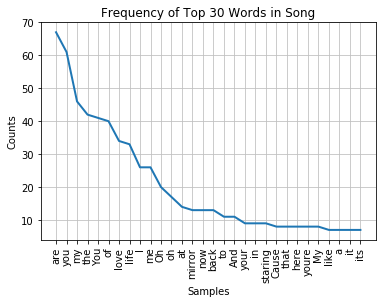

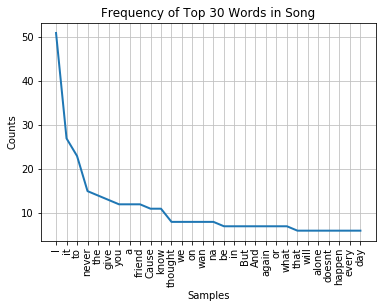

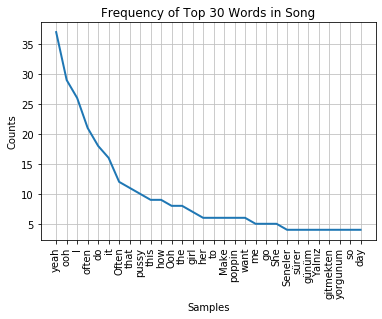

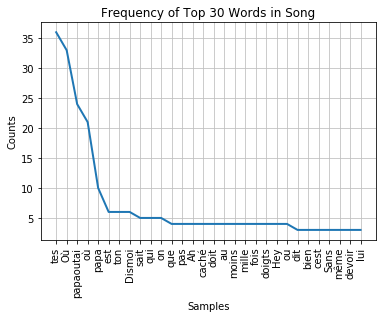

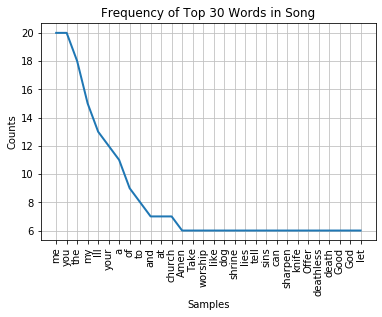

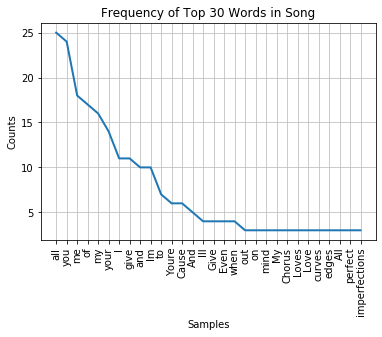

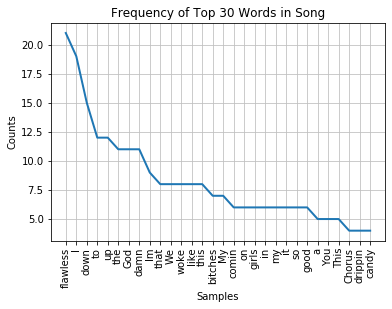

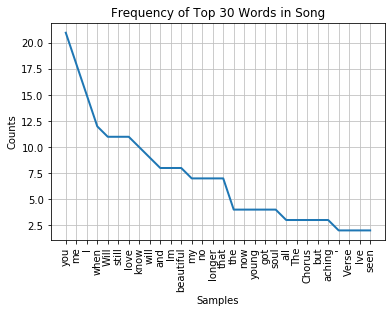

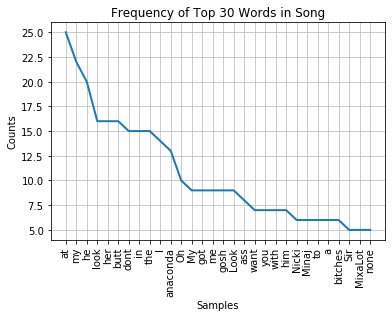

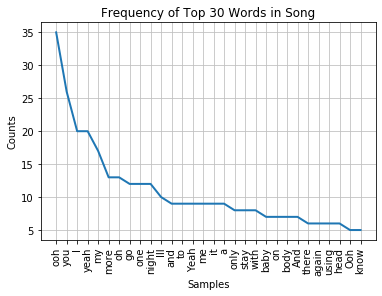

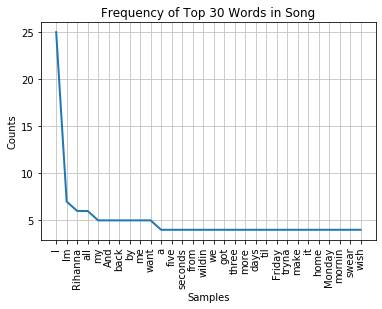

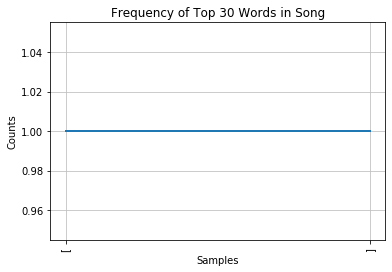

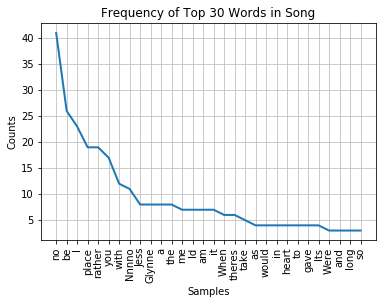

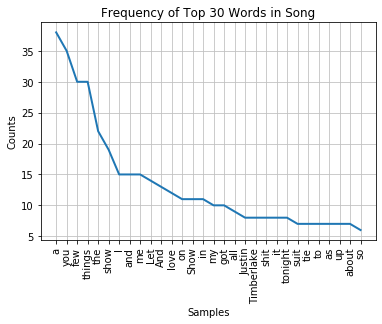

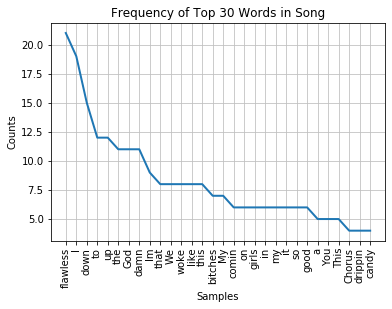

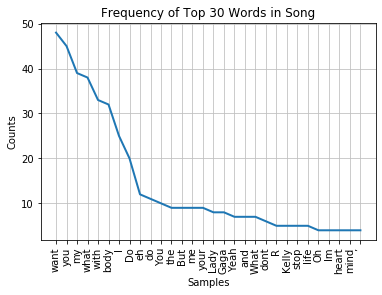

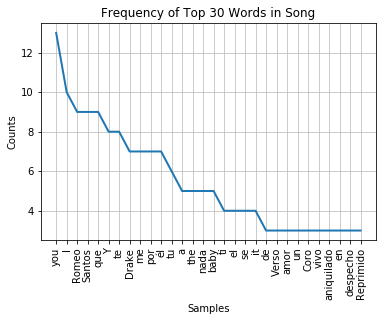

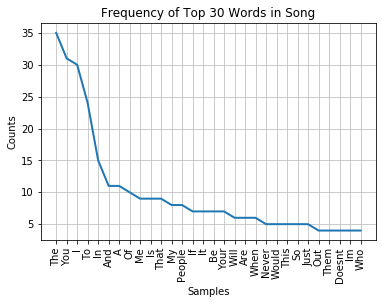

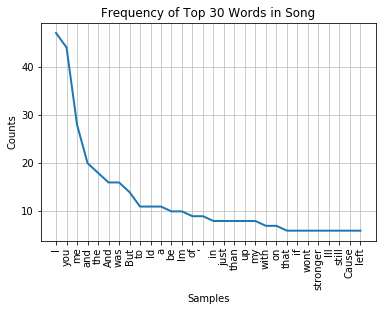

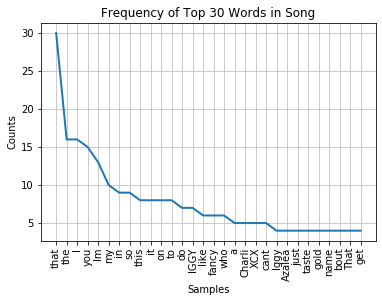

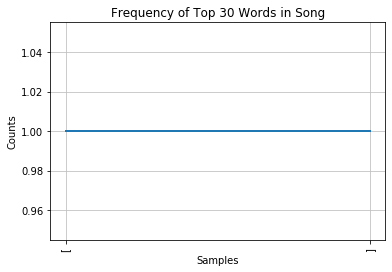

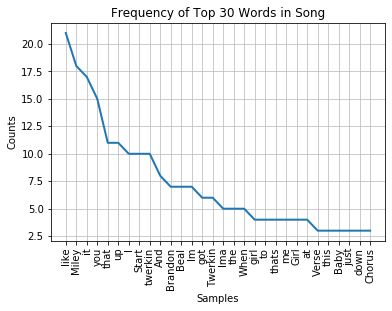

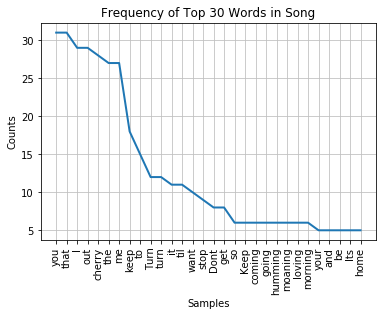

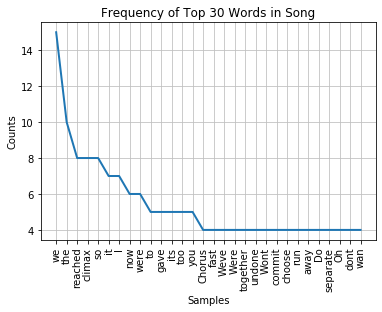

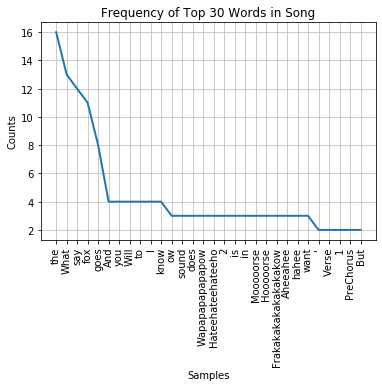

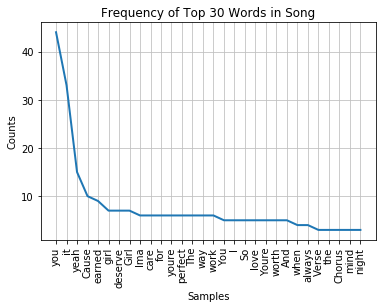

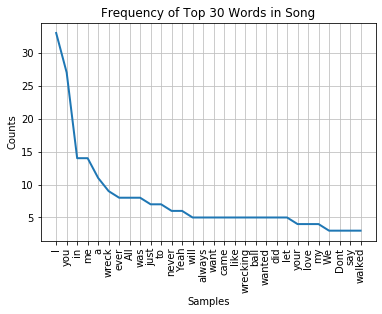

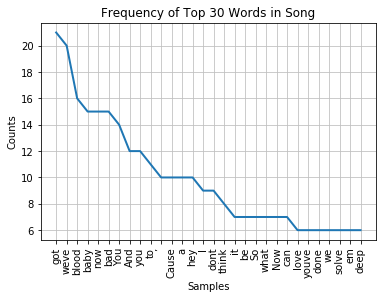

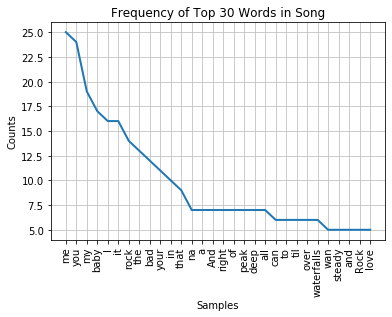

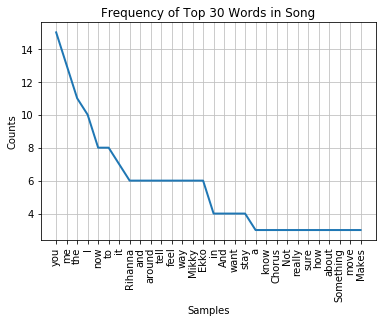

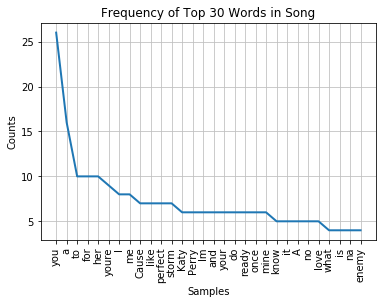

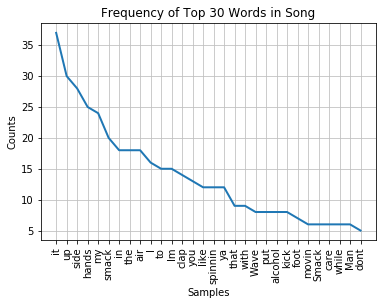

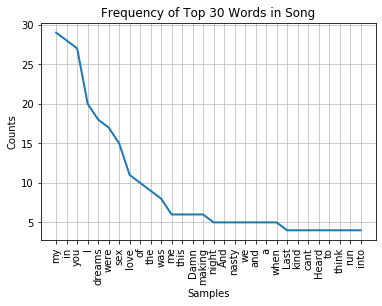

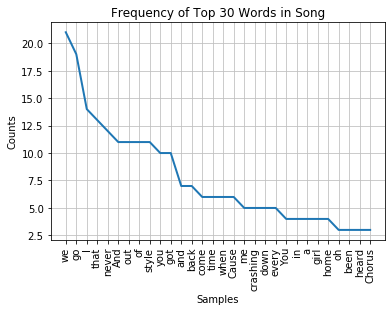

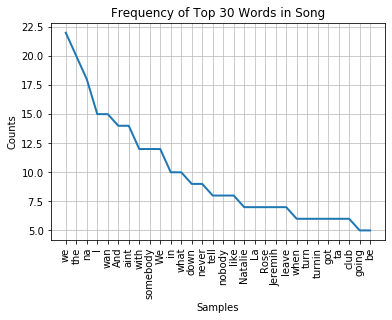

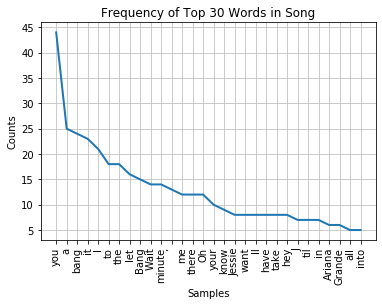

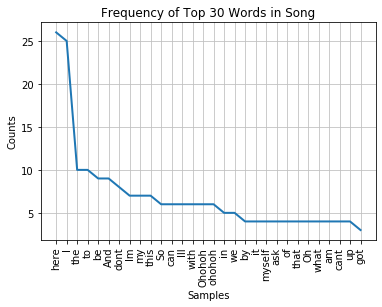

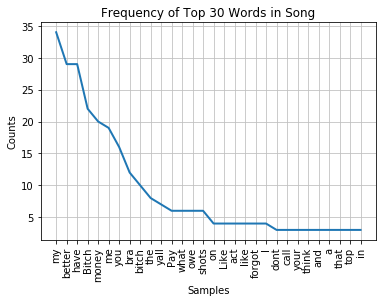

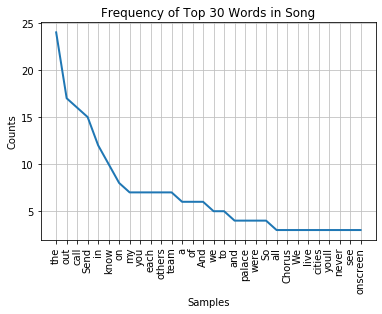

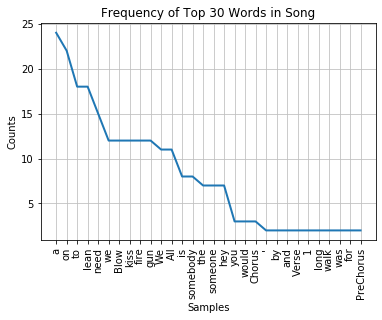

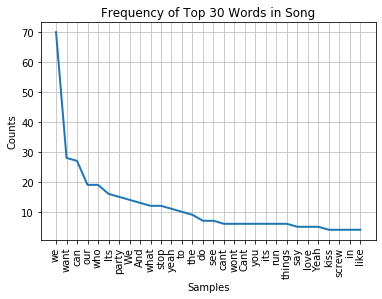

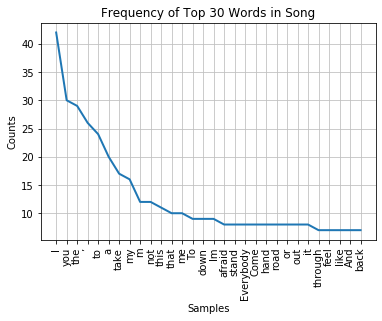

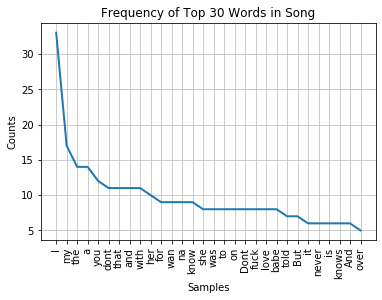

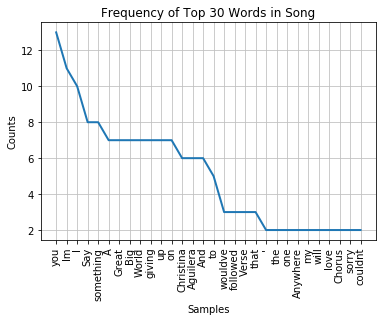

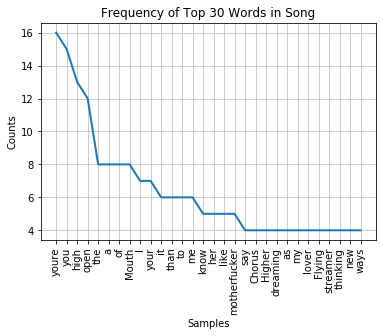

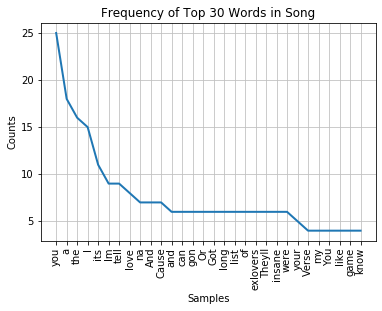

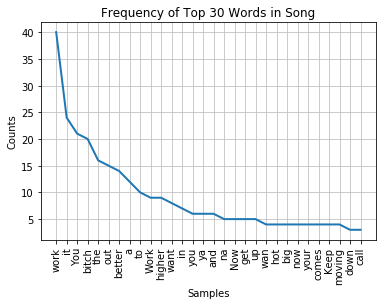

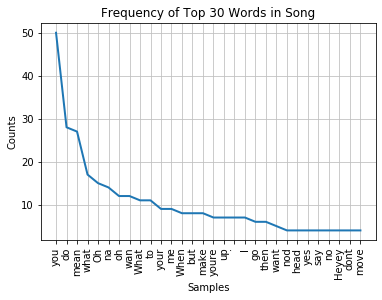

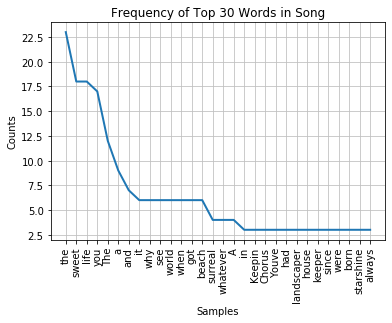

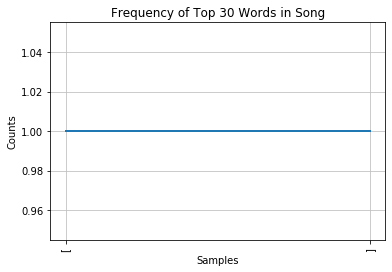

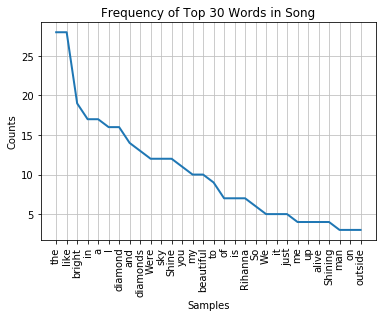

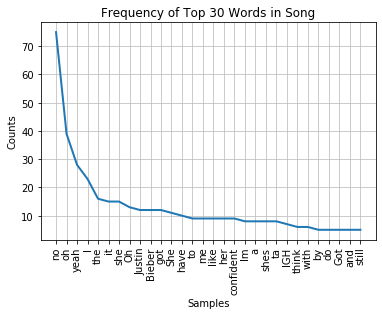

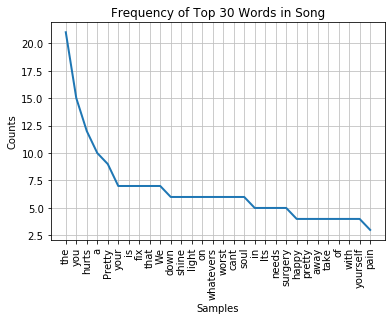

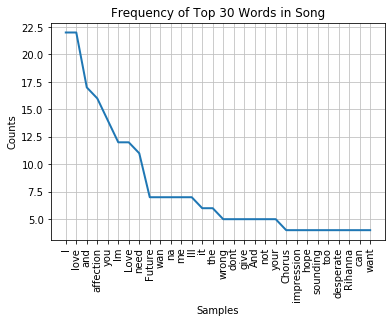

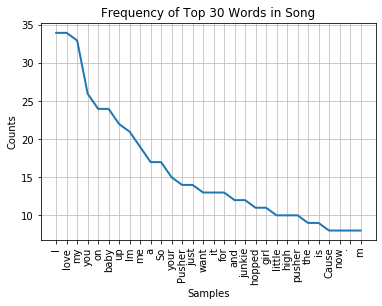

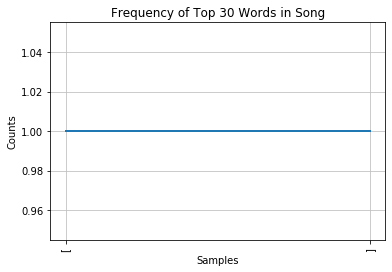

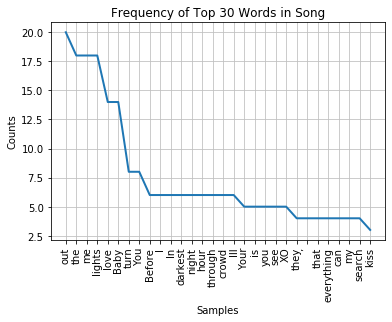

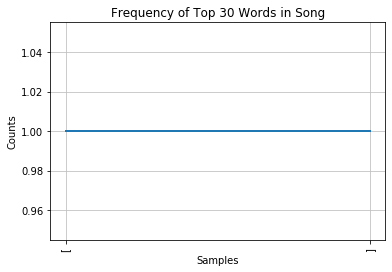

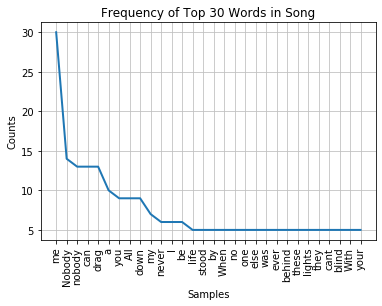

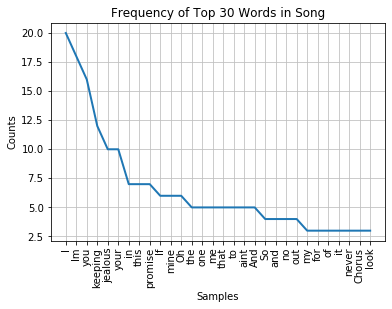

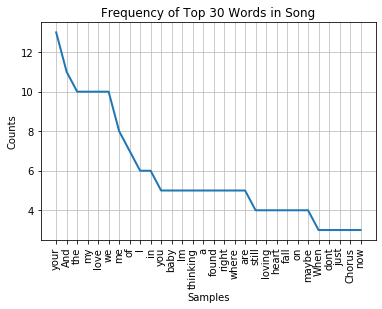

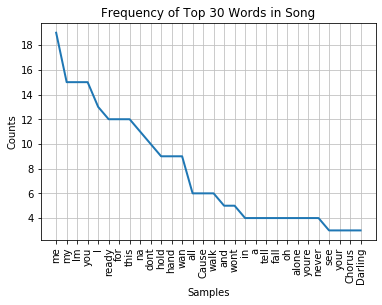

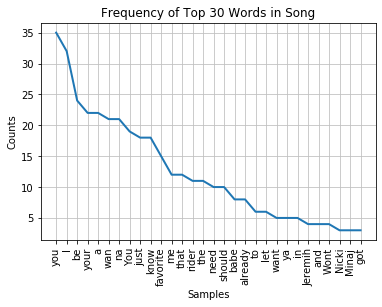

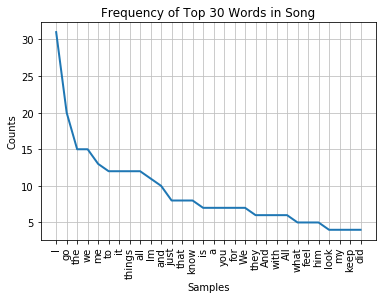

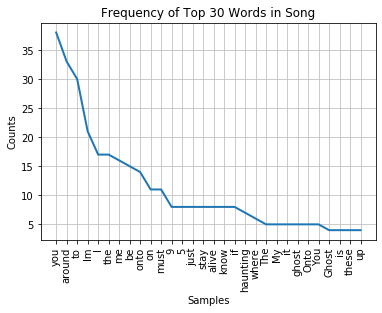

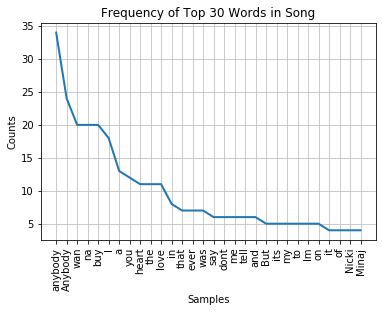

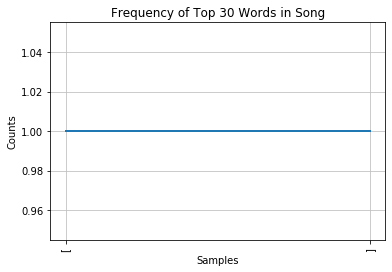

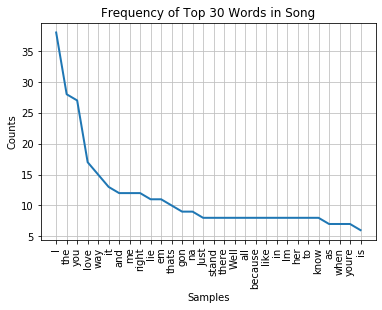

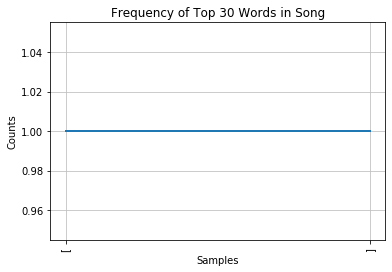

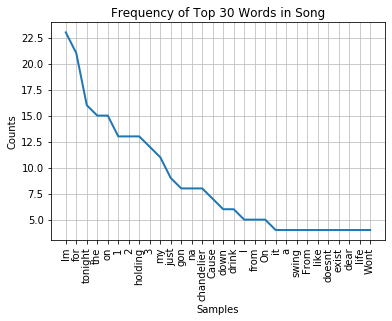

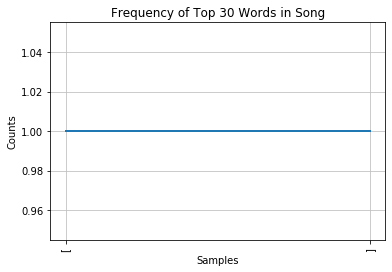

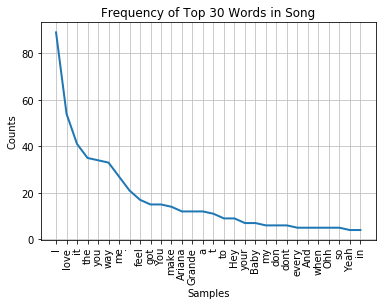

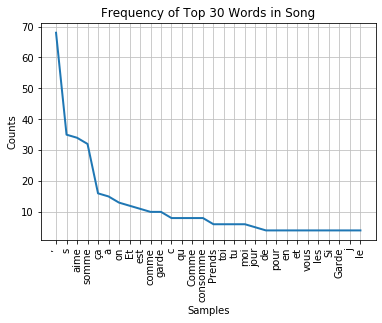

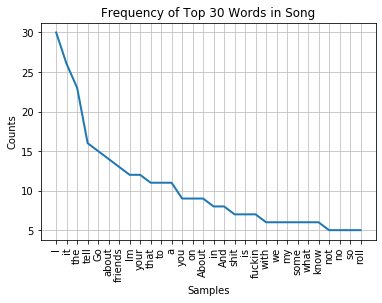

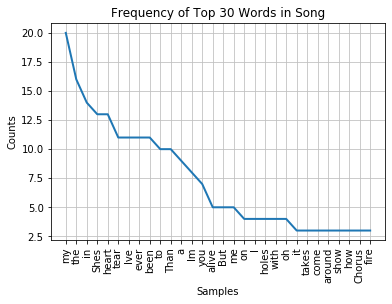

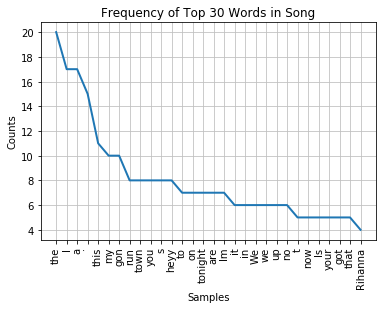

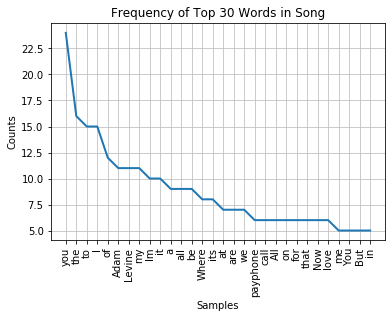

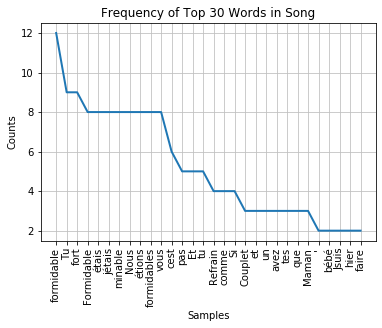

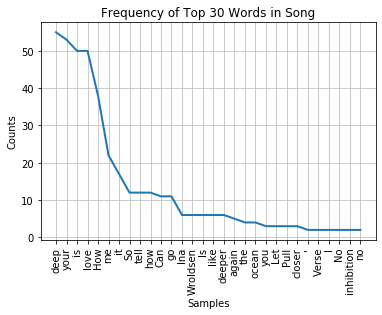

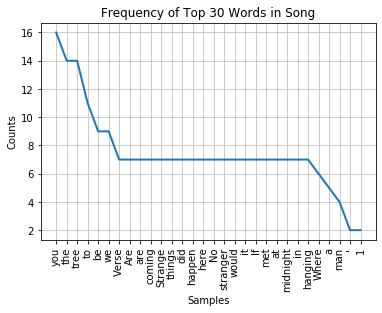

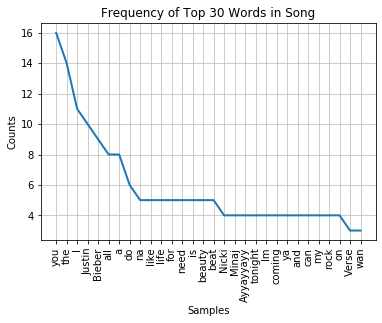

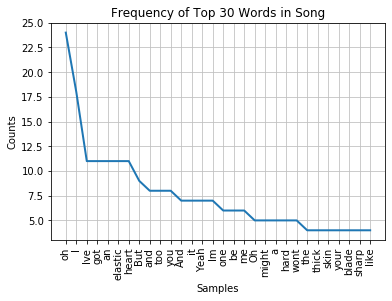

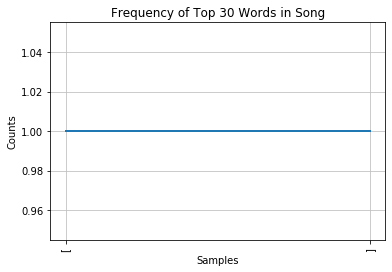

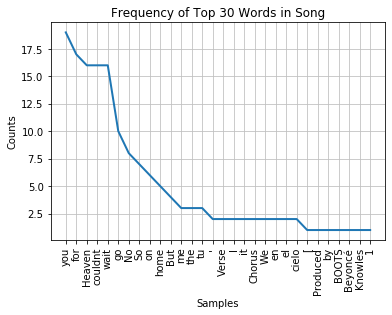

In [30]:
most_common_words = []
fdist = []
for i in words:
    fdist1 = FreqDist(i)
    most_common = fdist1.most_common(10)
    fdist.append(fdist1)
    most_common_words.append(most_common)
fig, ax = plt.subplots()
for i in fdist:
    plt.title('Frequency of Top 30 Words in Song')
    i.plot(30,cumulative=False)

In [31]:
# THIS ALSO TAKES A LONG TIME TO RUN
# songs = list(map(itemgetter('song'), dictionary))
# most_common_df = pd.DataFrame(most_common_words, columns = ['First', 'Second','Third','Fourth','Fifth', 'Sixth','Seventh'
#                                                           ,'Eighth','Ninth', 'Tenth'], index = songs)
# most_common_df.head()


In [32]:
# with open('most_common_df.pickle', 'wb') as f:
#     pickle.dump(most_common_df, f)

with open('most_common_df.pickle', 'rb') as f:
    most_common_df = pickle.load(f)
most_common_df.head()

First      Second       Third      Fourth       Fifth       Sixth       Seventh       Eighth       Ninth        Tenth
Drunk-In-Love    (I, 24)   (all, 21)  (love, 21)    (in, 18)   (the, 18)    (We, 14)    (that, 13)     (my, 13)   (you, 13)     (be, 13)
The-Hills       (me, 26)   (you, 24)   (the, 20)  (only, 19)     (I, 16)    (Im, 14)  (fucked, 13)     (up, 13)  (when, 12)   (When, 12)
Blurred-Lines  (you, 40)     (I, 27)    (it, 24)  (know, 18)  (want, 18)   (Hey, 17)      (me, 17)    (get, 16)     (a, 13)  (Robin, 12)
The-Monster     (Im, 24)   (the, 24)     (I, 20)    (to, 16)   (you, 16)  (with, 15)      (my, 14)  (think, 14)    (me, 13)  (thats, 12)
Thrift-Shop     (Im, 30)  (what, 21)     (a, 21)    (in, 16)     (I, 16)  (bada, 14)    (that, 14)    (the, 12)  (some, 11)     (my, 11)

Now we can filter out stop words for the most common words.

In [33]:
filter_s = []
for most_common_words[0] in most_common_words:
    for w in most_common_words[0]: 
        if w not in stop_words: 
            filter_s.append(w) 
filter_s[:20]

[('I', 24),
 ('all', 21),
 ('love', 21),
 ('in', 18),
 ('the', 18),
 ('We', 14),
 ('that', 13),
 ('my', 13),
 ('you', 13),
 ('be', 13),
 ('me', 26),
 ('you', 24),
 ('the', 20),
 ('only', 19),
 ('I', 16),
 ('Im', 14),
 ('fucked', 13),
 ('up', 13),
 ('when', 12),
 ('When', 12)]

Sort_Tuple will give a function that finds the top words used in all of the songs, without any stop words. 

In [34]:
def Sort_Tuple(tup):
    '''
    this function takes all of the most common words from the filtered list of words in lyrics (ie. no stop words)
    and then sorts the words by the frequency of their appearance
    '''
    d = {x:0 for x, _ in tup} 
    for name, num in tup: d[name] += num 
  
    Output = list(map(tuple, d.items())) 
    return(sorted(Output, key = lambda Output: Output[1],reverse = True))
  
sorted_words=Sort_Tuple(filter_s)
sorted_words[:20]

[('I', 2918),
 ('you', 2826),
 ('the', 1952),
 ('me', 1104),
 ('my', 1084),
 ('a', 856),
 ('it', 838),
 ('to', 740),
 ('Im', 694),
 ('love', 662),
 ('in', 416),
 ('we', 382),
 ('that', 376),
 ('your', 368),
 ('up', 318),
 ('and', 300),
 ('all', 298),
 ('na', 284),
 ('You', 268),
 ('And', 260)]

Text(0.5, 1.0, 'Frequency of Words in Top 100 Songs')

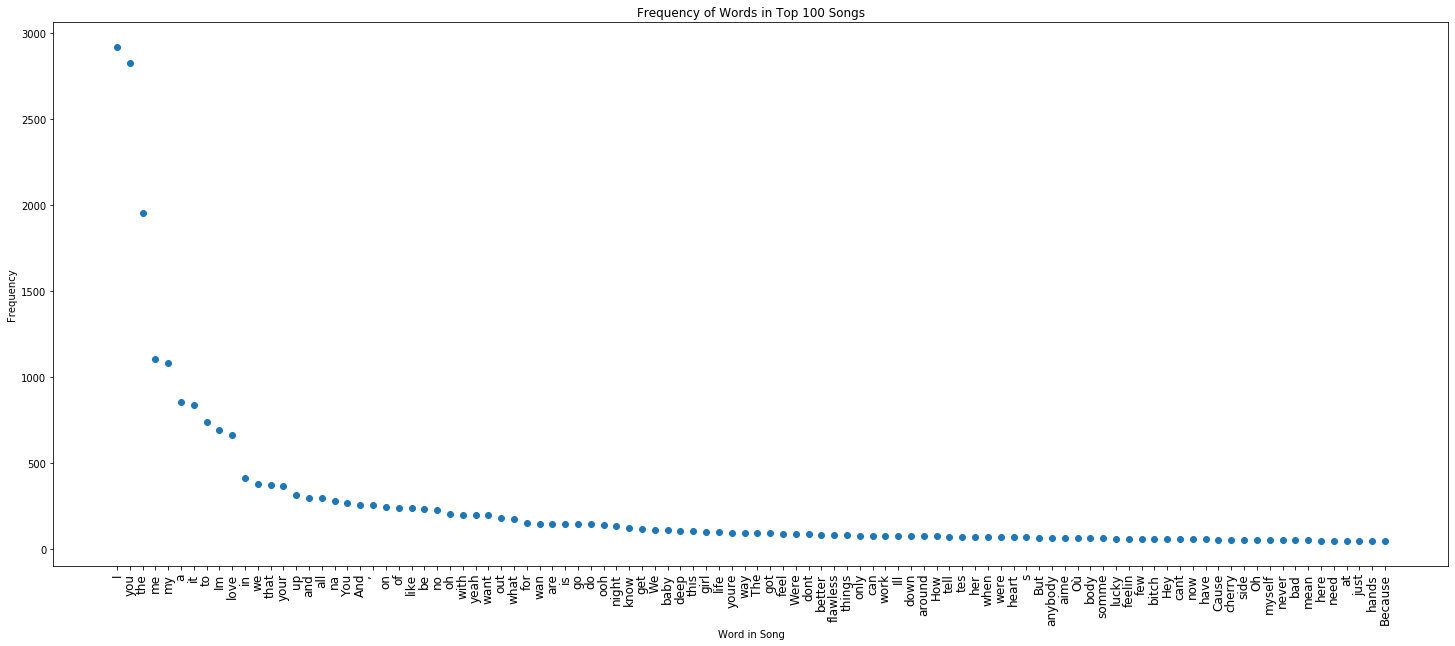

In [35]:
#plot the most common words in all songs
testList2 = [(elem1, elem2) for elem1, elem2 in sorted_words]
plt.figure(figsize=(25,10))
plt.xticks(rotation=90,fontsize=12)
plt.scatter(*zip(*testList2[:100]))
plt.xlabel('Word in Song')
plt.ylabel('Frequency')
plt.title('Frequency of Words in Top 100 Songs')


## Initial Model and Revised Research Question
Given the sources we have, it seems the most interesting question we could investigate is the automatic playlist generation problem, or song radio creation--given a single song (or a whole playlist), generate proposed songs that the user might like. So, for our initial model, we decided to use the Million Playlist Dataset in conjunction with the Spotify API to generate a "next up on the radio" song given an input song from the user. Again, we didn't see a way to incorporate the song lyrics, so we left them out.

In the initial base model below, we take an input song via its URI, and select all playlists that contain the given song. Then, we find the intersection of the songs in the selected playlists, and remove from this intersection the set of songs in all the playlists, as we want to exclude songs that are so popular that they do not give us much information about specific music taste. This operates on the assumption that if a person likes a particular song, they may also like the music liked by other people who like that song. Essentially, we find other people who also like that song, find the songs that all of them like, excluding extremely popular songs, which will be our list of potential songs. 

Then, we use the Spotify API to get the audio features of these potential songs. Based purely on gut instinct, we decided that the most relevant audio features were: danceability, energy, acousticness, instrumentalness, and valence. For our final model, we would use cross-validation to select the most relevant predictors. We then used the sum of the squared difference of those audio features between the input song and the potential songs to assign each potential song a score, and then output the song with the lowest score (most similar to the input song).  

In [46]:
def find_playlists_with_song(song):
    return all_songs.loc[all_songs['track_name'] == song].playlist_id.unique() 
def find_common_songs(playlists):
    return reduce(set.intersection, [set(pl.track_name.unique()) for pl in playlists ])
basic = find_common_songs(playlists)

In [104]:
uris_sorted = []
def base_model(track_uri, n):
    playlist_ids = all_songs.loc[all_songs['track_uri'] == track_uri].playlist_id.unique()
    playlists_with_song = [playlists[pl] for pl in find_playlists_with_song('Ezra')]
    common_songs = reduce(set.intersection, [set(pl.track_uri.unique()) for pl in playlists_with_song ])
    basic = reduce(set.intersection, [set(pl.track_uri.unique()) for pl in playlists ])
    potential = common_songs.difference(basic)
    target = list(potential)[1:n]
    rec_ids = [track[14:] for track in target]
    
    target_info = spotify.audio_features(track_uri[14:])
    tracks_info = spotify.audio_features(rec_ids)
    tracks_scores = dict()
    for i, track in enumerate(tracks_info):
        tracks_scores[str(rec_ids[i])] = (target_info[0]['danceability'] - track['danceability'])**2 + (target_info[0]['energy'] - track['energy'])**2 +(target_info[0]['acousticness'] - track['acousticness'])**2 + (target_info[0]['instrumentalness'] - track['instrumentalness'])**2 + (target_info[0]['valence'] - track['valence'])**2
    sorted_scores = sorted(tracks_scores.items(), key=operator.itemgetter(1))
    list_scores = [item[0] for item in sorted_scores]

    for i in range(0,11):
        uri_of_songs = spotify.track(list_scores[i])['uri']
        uris_sorted.append(uri_of_songs)
    #return sorted_scores[0:10], spotify.track(sorted_scores[0][0])
    return uris_sorted

example = base_model('spotify:track:0zG9M0rfjwe9gwsaQXN071', 30)

In [106]:
unique_song_list = []
for i in example:
    unique_song_list.append(all_songs.track_name.loc[all_songs.track_uri == i].drop_duplicates(
        keep='first').tolist())

In [107]:
unique_song_list

[['Coming Home'],
 ['Up Down (Do This All Day)'],
 ["I'm A Mess"],
 ['untitled 07 | 2014 - 2016'],
 ['End Of The Road'],
 ['Teenage Dirtbag'],
 ['Zero To Hero'],
 ['Black Magic Woman'],
 ["Runnin' With The Devil - 2015 Remastered Version"],
 ['We Come Running'],
 ['Coming Home']]

For our final model, we'd like to split up the Million Playlist dataset into train and test sets, and train a neural network to predict the rest of a playlist given the first quarter of the playlist, using the sudio features as predictors. We would also like to attempt to incorporate more predictors outside of audio features, such as artist, album, genre, date of release, etc. 